# Analysis Notebook


In this notebook, we include all the experiments run during the exploratory analysis of BARTScore. As part of any analysis, we should be familiar with the details of the datasets. We collected the details and summarize them in the next section. 


## Datasets


BARTScore paper uses a total of 6 summarization, 3 data-to-text datasets, and 1 machine translation dataset (but explore 7 language pairs). Depending on the datasets and on their annotations, the authors evaluate different aspects of quality.



In [1]:
import pickle

def read_pickle(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data

In [2]:
len(read_pickle("./WMT/gu-en/data.pkl"))

20110

This is the demo to showcase some analysis process. For the analysis for each task, we have provided a corresponding class. 

In [3]:
# import analysis tools
from analysis import SUMStat, D2TStat, WMTStat

def truncate_print(l, n=10):
    """ Print the first n items of a list"""
    for i, x in enumerate(l):
        if i == n:
            print('...')
            break
        print(x)

## Summarization

For all summarization datasets, including **REALSumm**, **SummEval** and **Newsroom**, the analysis tools are the same.

In [5]:
summ_stat = SUMStat('SUM/REALSumm/final_p.pkl') # The path to the scored file, _p means we have prompted metrics

See what metrics are out there.<br>
Since there are a lot, including P, R, F variants for some metrics as well as prompted metrics, we only print a truncated version of metrics

In [6]:
print('[All metrics]')
truncate_print(summ_stat.metrics) # change to print if you want to see all metrics
print('[Automatic metrics]')
truncate_print(summ_stat.auto_metrics)
print('[Human metrics]')
truncate_print(summ_stat.human_metrics)

[All metrics]
litepyramid_recall
bert_score_p
bert_score_r
bert_score_f
mover_score
bart_score_src_hypo
bart_score_hypo_ref
bart_score_ref_hypo
bart_score_avg_f
bart_score_harm_f
...
[Automatic metrics]
bert_score_p
bert_score_r
bert_score_f
mover_score
bart_score_src_hypo
bart_score_hypo_ref
bart_score_ref_hypo
bart_score_avg_f
bart_score_harm_f
bart_score_cnn_src_hypo
...
[Human metrics]
litepyramid_recall


In [7]:
summ_stat.data[1].keys()#["sys_summs"].keys()

dict_keys(['src', 'ref_summ', 'sys_summs'])

In [8]:
summ_stat.data[1]["sys_summs"].keys()

dict_keys(['presumm_out_trans_abs.txt', 'two_stage_rl_out.txt', 'unilm_out_v2.txt', 't5_out_large.txt', 'presumm_out_ext_abs.txt', 'ptr_generator_out_pointer_gen_cov.txt', 'bart_out.txt', 'fast_abs_rl_out_rerank.txt', 't5_out_11B.txt', 'presumm_out_abs.txt', 'bottom_up_out.txt', 'unilm_out_v1.txt', 't5_out_base.txt', 'semsim_out.txt', 'neusumm_out.txt', 'pnbert_out_lstm_pn_rl.txt', 'refresh_out.txt', 'heter_graph_out.txt', 'pnbert_out_bert_tf_sl.txt', 'banditsumm_out.txt', 'pnbert_out_bert_lstm_pn_rl.txt', 'pnbert_out_bert_tf_pn.txt', 'matchsumm_out.txt', 'pnbert_out_bert_lstm_pn.txt'])

In [9]:
summ_stat.data[1]["sys_summs"]["bart_out.txt"]

{'sys_summ': 'The money was collected from students at the University of Surrey . Currency was submerged in agar - a substance that allows bacteria to grow quickly - and then monitored for three to four days . The students found thousands of bacteria colonies living on the sample of money . Most of the bacteria found on the coins studied was harmless . But MRSA and food poisoning bacteria have been found on money in previous studies . One ten pound note yielded Bacillus mycoides , which is common in soil , suggesting that someone was gardening before handling cash . The scientists found cases of staphylococcus aureus , which can cause boils and spots on the skin .',
 'scores': {'litepyramid_recall': 0.4545454545454545,
  'bert_score_p': tensor(0.2029),
  'bert_score_r': tensor(0.5115),
  'bert_score_f': tensor(0.3538),
  'mover_score': 0.2812629964850383,
  'bart_score_src_hypo': -0.9205112457275391,
  'bart_score_hypo_ref': -3.66383695602417,
  'bart_score_ref_hypo': -11.8475351333618

We can choose some metrics that we are interested in to conduct analysis.<br> 
For example, in **REALSumm**, we use recall-based metrics (e.g. bert_score_r, rouge1_r, bart_score_cnn_hypo_ref, ...)<br>
For others, we use F-based metrics (for metrics that only consider hypo and ref) and src->hypo (for generation based metrics like bart_score and prism)

In [10]:
valid_metrics = [
    'rouge1_r',
    'rouge2_r',
    'rougel_r',
    'bert_score_r',
    'mover_score',
    'prism_hypo_ref',
    'bart_score_cnn_hypo_ref'
]

# The first argument is the human metric considered.
# The second argument is a list of considered automatic metrics, can omit it if all automatic metrics are considered
summ_stat.evaluate_summary('litepyramid_recall', valid_metrics) 

Human metric: litepyramid_recall
metric                     spearman    kendalltau
-----------------------  ----------  ------------
rouge1_r                   0.497526      0.407974
rougel_r                   0.488254      0.402523
bart_score_cnn_hypo_ref    0.474608      0.374497
bert_score_r               0.440398      0.346489
rouge2_r                   0.4233        0.353119
prism_hypo_ref             0.411005      0.323994
mover_score                0.372353      0.290156


We can also see the performance of some prompt-based metrics.

### Analysis

Play around w/ BARTScore scores in different datasets.
- [ ] break down Kendall Tau results and examine its discrepancies w/ human judgements
- [ ] are there task-specific errors

In the case of RealSumm the metrics of interest are: 
- __human metrics__: `litepyramid_recall`
- __learned metric__: `bart_score_cnn_hypo_ref`

In [11]:
def get_dataframe(data, human_metric):

    print("Evaluation dataset:", len(data), "examples")
    print("Comparing metrics", human_metric)

    from collections import defaultdict
    model_data = defaultdict(list)

    for doc_id, doc_metadata in data.items():
        doc_models_metadata = doc_metadata["sys_summs"]

        for model_name, model_metadata in doc_models_metadata.items():
            model_data["id"].append(doc_id)
            model_data["src"].append(doc_metadata["src"])
            model_data["reference"].append(doc_metadata["ref_summ"])
            model_data["model"].append(model_name)
            
            model_data["candidate"].append(model_metadata["sys_summ"])
            model_data["human_score"].append(model_metadata["scores"][human_metric])
            
            for metric, score in model_metadata["scores"].items():
                if metric != human_metric:
                    model_data[metric].append(float(score))


    import pandas as pd
    return pd.DataFrame(model_data).sort_values(by="id")


model_data = get_dataframe(summ_stat.data, "litepyramid_recall")
model_data.head()

Evaluation dataset: 100 examples
Comparing metrics litepyramid_recall


,id,src,reference,model,candidate,human_score,bert_score_p,bert_score_r,bert_score_f,mover_score,...,bart_score_cnn_avg_f_de_To be specific,bart_score_cnn_harm_f_de_To be specific,bart_score_cnn_ref_hypo_en,bart_score_cnn_ref_hypo_de,bart_score_cnn_hypo_ref_en,bart_score_cnn_hypo_ref_de,bart_score_cnn_avg_f_en,bart_score_cnn_avg_f_de,bart_score_cnn_harm_f_en,bart_score_cnn_harm_f_de
1809,0,( cnn ) two cnn heroes are among the earthquak...,Anuradha Koirala and 425 young women and girls...,presumm_out_abs.txt,Anuradha koirala has a rehab center in kathman...,0.0,0.278758,0.247021,0.264038,0.101913,...,-3.281988,-1.584504,-2.483502,-2.761642,-3.703487,-3.885131,-3.093494,-3.323387,-1.486583,-1.614040
1801,0,( cnn ) two cnn heroes are among the earthquak...,Anuradha Koirala and 425 young women and girls...,two_stage_rl_out.txt,Anuradha koirala is the founder of maiti nepal...,0.1,0.210054,0.178377,0.195475,0.016639,...,-3.770746,-1.874277,-3.324501,-3.562252,-3.918261,-4.080406,-3.621381,-3.821329,-1.798506,-1.901817
1802,0,( cnn ) two cnn heroes are among the earthquak...,Anuradha Koirala and 425 young women and girls...,unilm_out_v2.txt,Two cnn heroes are among the earthquake surviv...,0.5,0.257093,0.359413,0.308881,0.290888,...,-2.763418,-1.378526,-2.632117,-2.930829,-2.408297,-2.696626,-2.520207,-2.813727,-1.257599,-1.404299
1803,0,( cnn ) two cnn heroes are among the earthquak...,Anuradha Koirala and 425 young women and girls...,t5_out_large.txt,Cnn heroes anuradha koirala and pushpa basu ar...,0.2,0.166144,0.112345,0.140499,0.022013,...,-3.909444,-1.951297,-3.854784,-4.154273,-3.552139,-3.812238,-3.703462,-3.983256,-1.848614,-1.987822
1804,0,( cnn ) two cnn heroes are among the earthquak...,Anuradha Koirala and 425 young women and girls...,presumm_out_ext_abs.txt,Anuradha koirala rescues victims of sex traffi...,0.1,0.237865,0.223772,0.232058,0.099405,...,-3.450529,-1.673068,-2.732934,-2.897373,-3.889542,-4.060446,-3.311238,-3.478910,-1.605094,-1.690687


In [12]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Math processing
import numpy as np

#### Dataset-wise analysis

#### Length RealSumm

In [13]:
summ_stat = SUMStat('SUM/REALSumm/final_p.pkl') # The path to the scored file, _p means we have prompted metrics
realsumm = get_dataframe(summ_stat.data, "litepyramid_recall")
print(len(realsumm), realsumm["src"].nunique())
realsumm["ref_words_len"] = realsumm["reference"].apply(lambda s: len(s.split()))
realsumm["cand_words_len"] = realsumm["candidate"].apply(lambda s: len(s.split()))
realsumm["src_words_len"] = realsumm["src"].apply(lambda s: len(s.split()))
realsumm.head(2)

Evaluation dataset: 100 examples
Comparing metrics litepyramid_recall
2400 100


,id,src,reference,model,candidate,human_score,bert_score_p,bert_score_r,bert_score_f,mover_score,...,bart_score_cnn_ref_hypo_de,bart_score_cnn_hypo_ref_en,bart_score_cnn_hypo_ref_de,bart_score_cnn_avg_f_en,bart_score_cnn_avg_f_de,bart_score_cnn_harm_f_en,bart_score_cnn_harm_f_de,ref_words_len,cand_words_len,src_words_len
1809,0,( cnn ) two cnn heroes are among the earthquak...,Anuradha Koirala and 425 young women and girls...,presumm_out_abs.txt,Anuradha koirala has a rehab center in kathman...,0.0,0.278758,0.247021,0.264038,0.101913,...,-2.761642,-3.703487,-3.885131,-3.093494,-3.323387,-1.486583,-1.614040,44,46,986
1801,0,( cnn ) two cnn heroes are among the earthquak...,Anuradha Koirala and 425 young women and girls...,two_stage_rl_out.txt,Anuradha koirala is the founder of maiti nepal...,0.1,0.210054,0.178377,0.195475,0.016639,...,-3.562252,-3.918261,-4.080406,-3.621381,-3.821329,-1.798506,-1.901817,44,49,986


In [14]:
realsumm["ref_words_len"] = realsumm["reference"].apply(lambda s: len(s.split()))
realsumm["cand_words_len"] = realsumm["candidate"].apply(lambda s: len(s.split()))
realsumm["src_words_len"] = realsumm["src"].apply(lambda s: len(s.split()))

In [15]:
# Correlation by model
models = sorted(realsumm.model.unique())

plt.figure(figsize=(5, 3), dpi=150)
sns.histplot(common_data["human_score"], color="purple")
plt.xlabel("RealSumm human score (coverage).")
plt.show()

print("==============")
common_data = realsumm[realsumm.model==models[0]]

plt.figure(figsize=(5, 3), dpi=150)
sns.histplot(common_data["src_words_len"], label="#words in source")
plt.show()

plt.figure(figsize=(5, 3), dpi=150)
sns.histplot(common_data["ref_words_len"], label="#words in ref")
plt.show()

plt.figure(figsize=(5, 3), dpi=150)
sns.histplot(common_data["ref_words_len"] + common_data["src_words_len"])
plt.xlabel("#words_ref + #words_src")
plt.show()


plt.figure(figsize=(5, 3), dpi=150)
sns.histplot((common_data["ref_words_len"] + common_data["src_words_len"]) / 0.4)
plt.xlabel("Rough estimate of necessary tokens for each src-ref pair")
plt.show()



if False:
    for model in models:

        cand_words_len = realsumm[realsumm.model == model]["cand_words_len"].copy()
        plt.figure(figsize=(5, 3), dpi=150)
        sns.histplot(cand_words_len, label=f"#words in {model} candidate")
        plt.xlabel(f"#words in {model} candidate")
        plt.show()

NameError: name 'common_data' is not defined

<Figure size 750x450 with 0 Axes>

## SummEval

In [18]:
summ_stat = SUMStat('SUM/SummEval/final_p.pkl') # The path to the scored file, _p means we have prompted metrics
summ_eval_coh = get_dataframe(summ_stat.data, "coherence")
summ_eval_con = get_dataframe(summ_stat.data, "consistency")
summ_eval_flu = get_dataframe(summ_stat.data, "fluency")
summ_eval_rel = get_dataframe(summ_stat.data, "relevance")


for dataset in (summ_eval_coh, summ_eval_con, summ_eval_flu, summ_eval_rel):    
    dataset["ref_words_len"] = dataset["reference"].apply(lambda s: len(s.split()))
    dataset["cand_words_len"] = dataset["candidate"].apply(lambda s: len(s.split()))
    dataset["src_words_len"] = dataset["src"].apply(lambda s: len(s.split()))

Evaluation dataset: 100 examples
Comparing metrics coherence
Evaluation dataset: 100 examples
Comparing metrics consistency
Evaluation dataset: 100 examples
Comparing metrics fluency
Evaluation dataset: 100 examples
Comparing metrics relevance


In [67]:
def plot_summeval_dists(dataset, human_label, plot_models=False):
    models = sorted(dataset.model.unique())
    common_data = dataset[dataset.model==models[0]]

    plt.figure(figsize=(5, 3), dpi=150)
    sns.histplot(common_data["human_score"], color="purple", binrange=(1,5))
    plt.xlabel(f"SummEval human score ({human_label}).")
    plt.show()
    
    print("==============")
    plt.figure(figsize=(5, 3), dpi=150)
    sns.histplot(common_data["src_words_len"], label="#words in source")
    plt.show()

    plt.figure(figsize=(5, 3), dpi=150)
    sns.histplot(common_data["ref_words_len"], label="#words in ref")
    plt.show()

    plt.figure(figsize=(5, 3), dpi=150)
    sns.histplot(common_data["ref_words_len"] + common_data["src_words_len"])
    plt.xlabel("#words_ref + #words_src")
    plt.show()


    plt.figure(figsize=(5, 3), dpi=150)
    sns.histplot((common_data["ref_words_len"] + common_data["src_words_len"]) / 0.4)
    plt.xlabel("Rough estimate of necessary tokens for each src-ref pair")
    plt.show()

    if plot_models:
        for model in models:
            cand_words_len = dataset[dataset.model == model]["cand_words_len"].copy()
            plt.figure(figsize=(5, 3), dpi=150)
            sns.histplot(cand_words_len, label=f"#words in {model} candidate")
            plt.xlabel(f"#words in {model} candidate")
            plt.show()

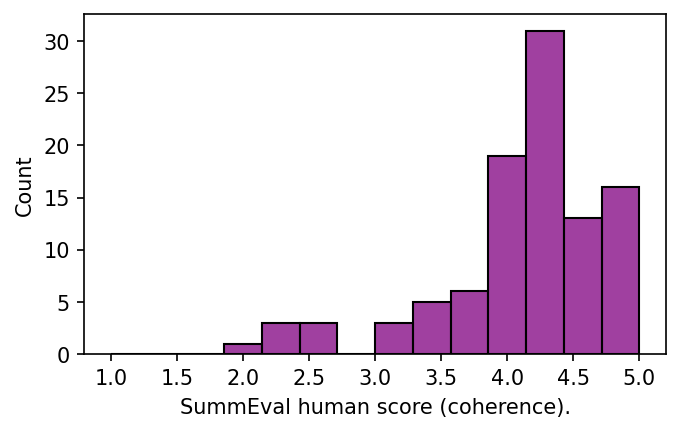

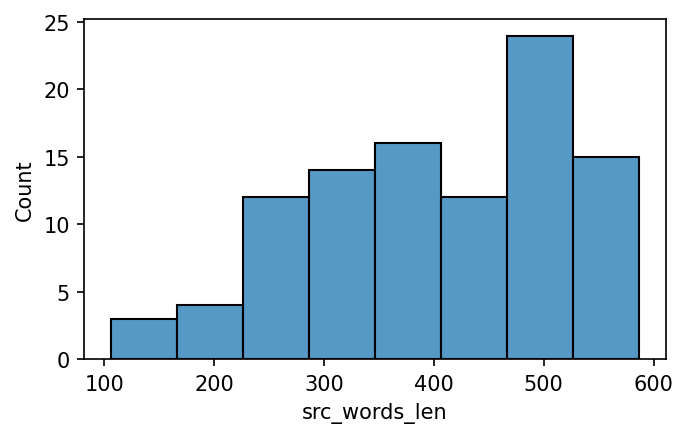

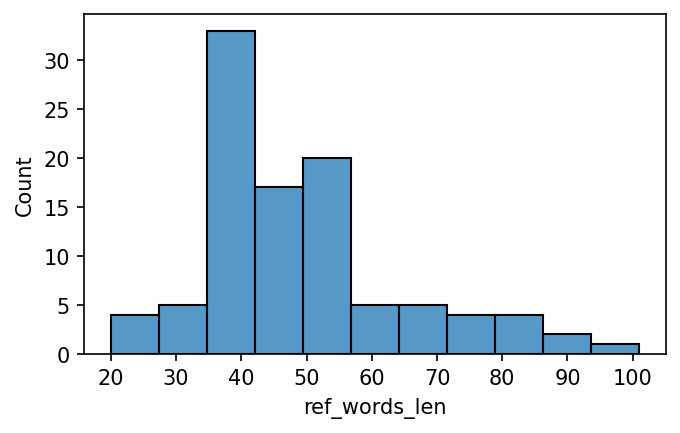

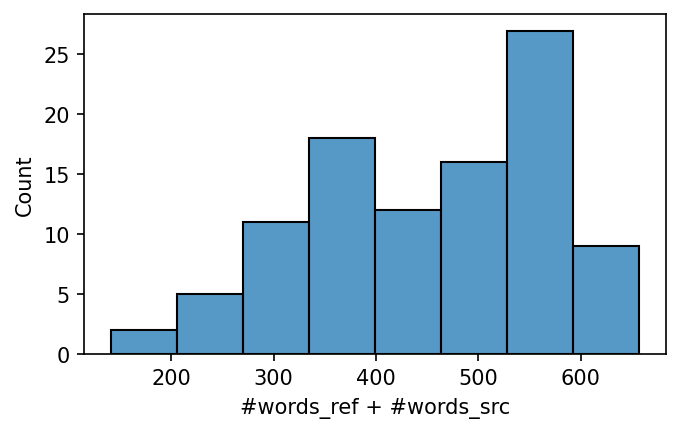

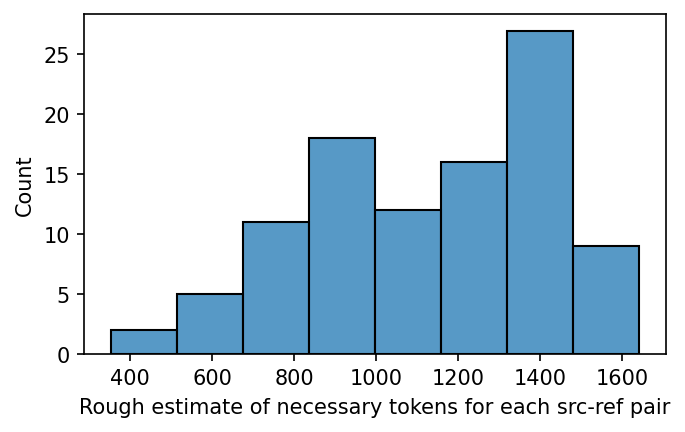

In [68]:
plot_summeval_dists(summ_eval_coh, "coherence")

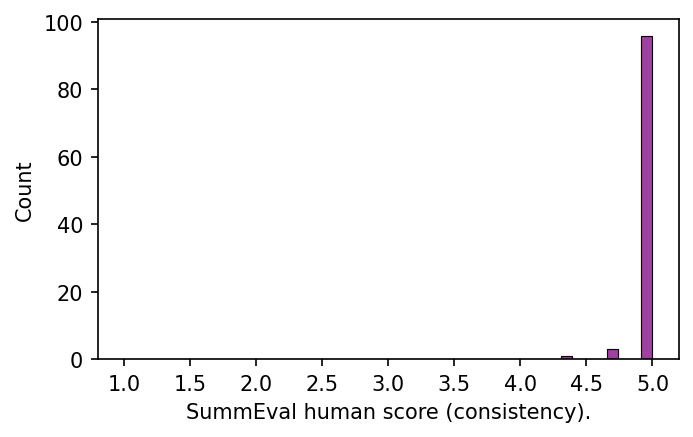

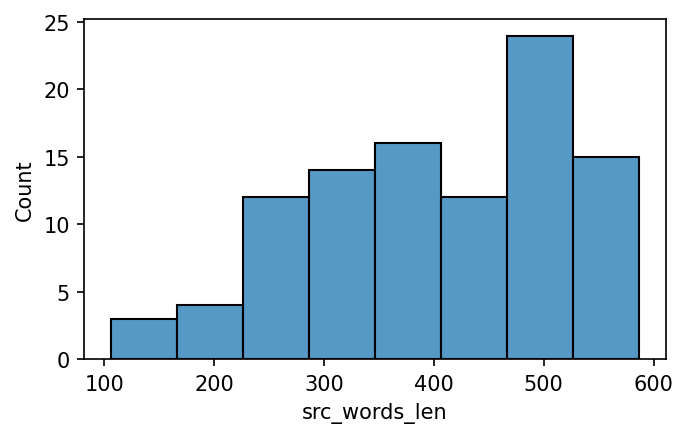

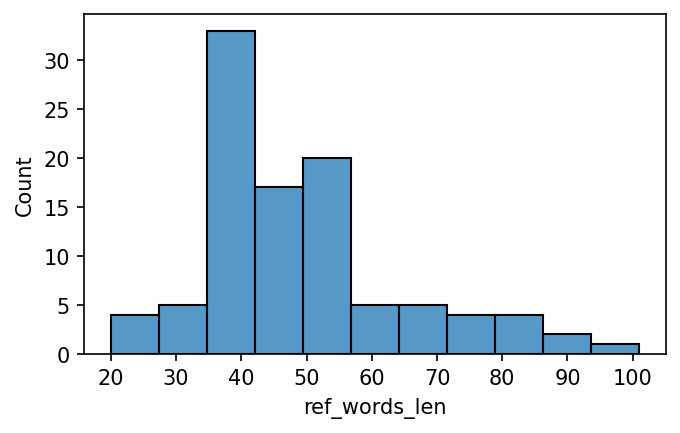

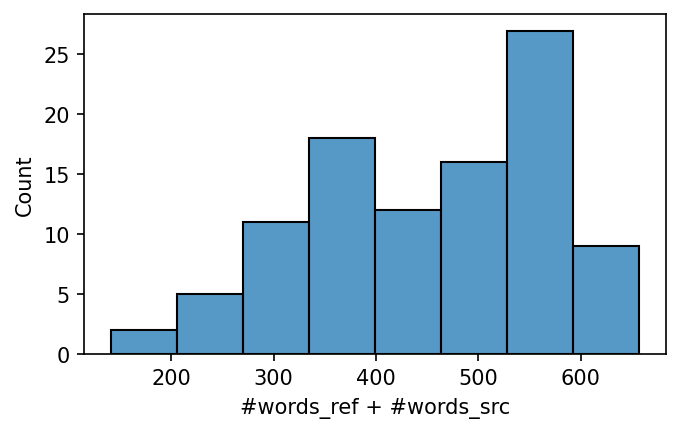

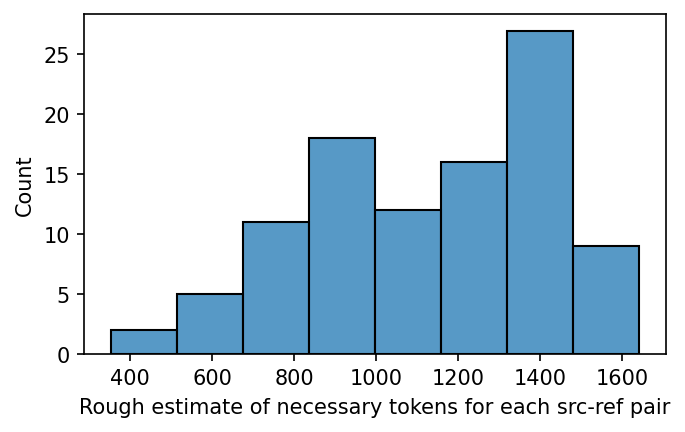

In [69]:
plot_summeval_dists(summ_eval_con, "consistency")

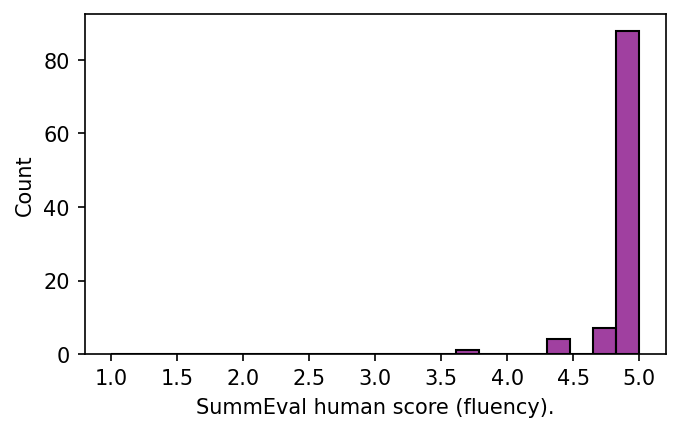

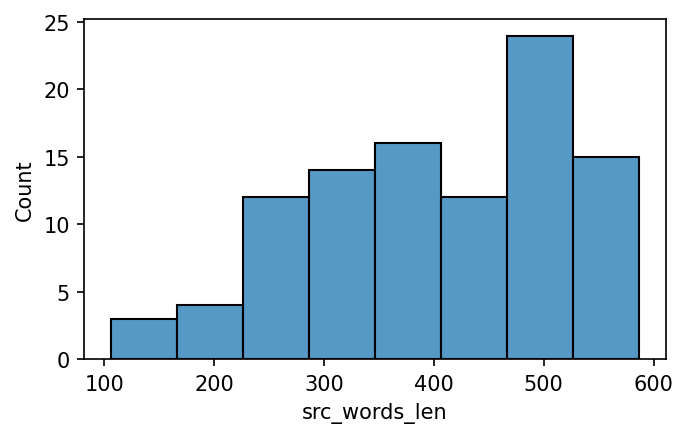

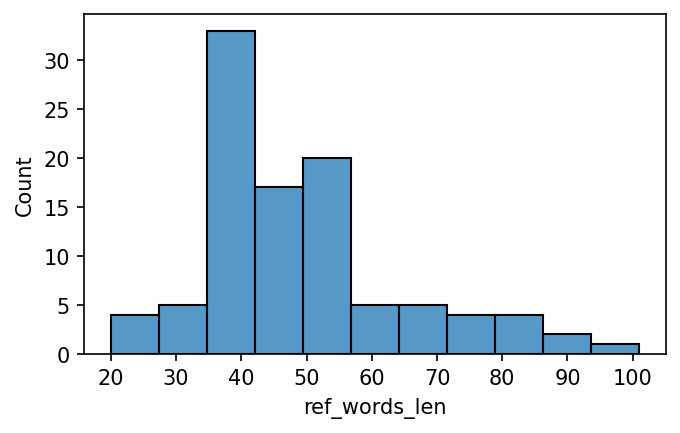

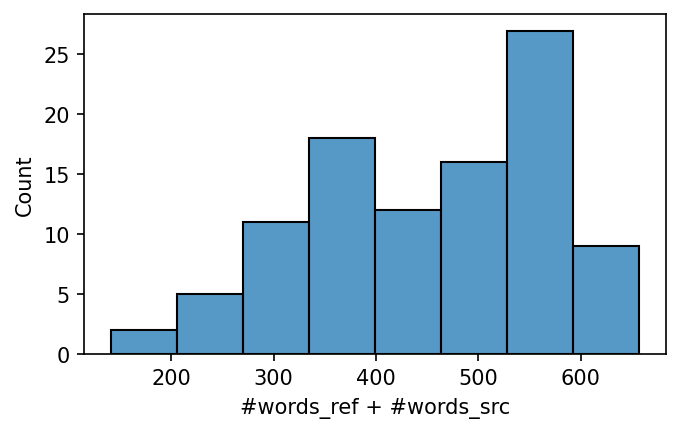

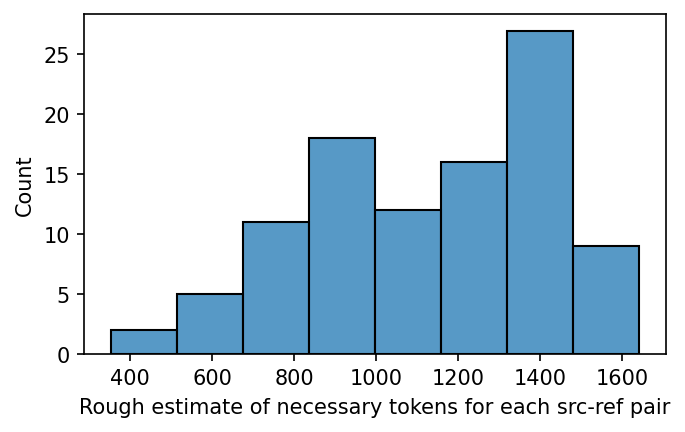

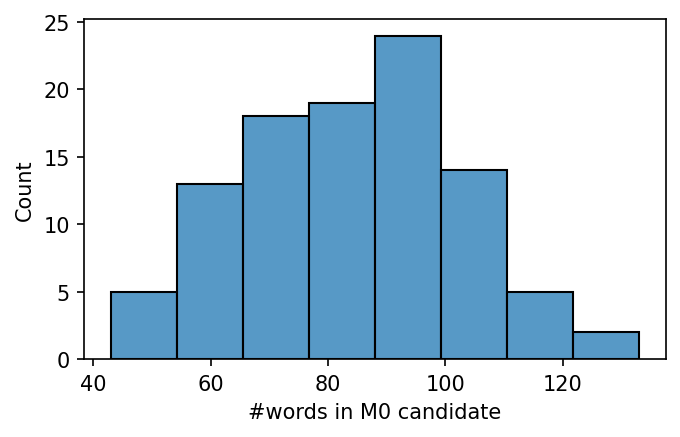

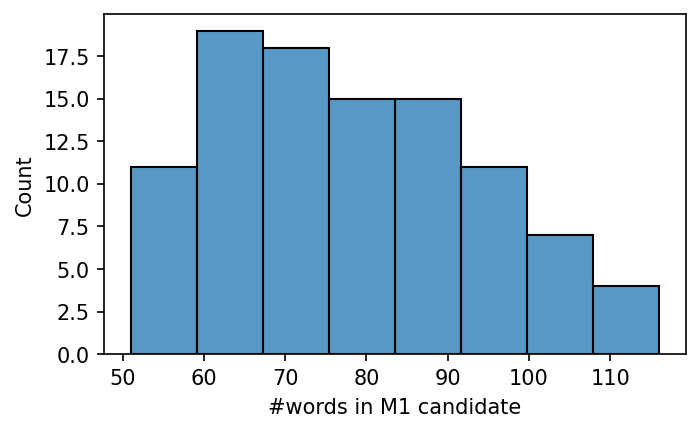

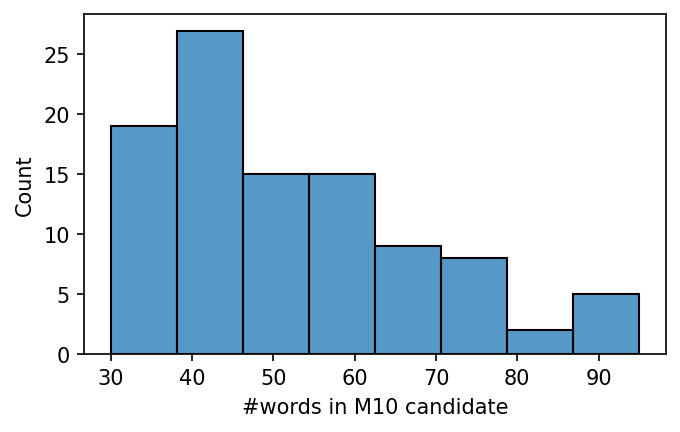

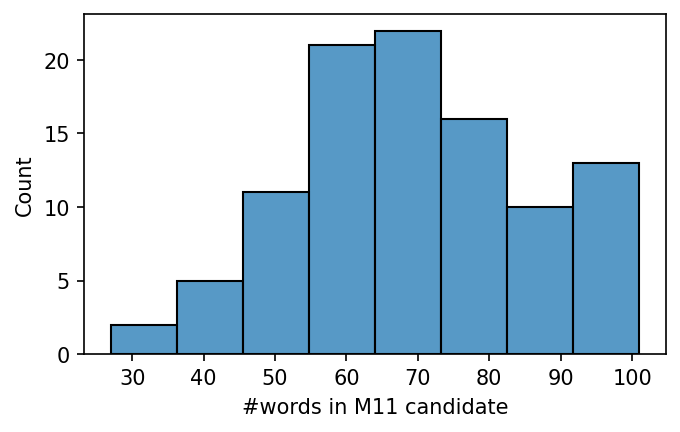

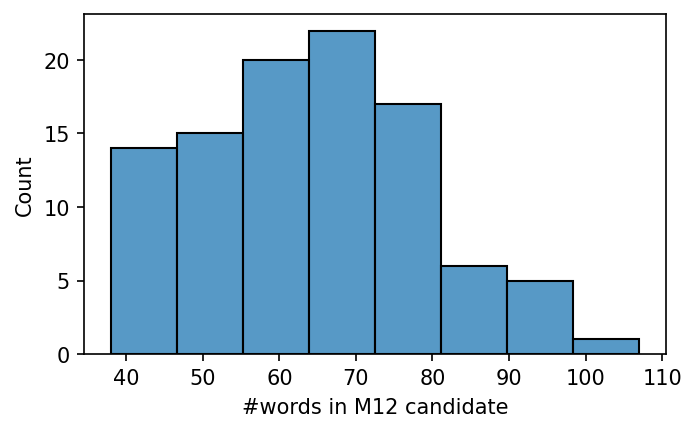

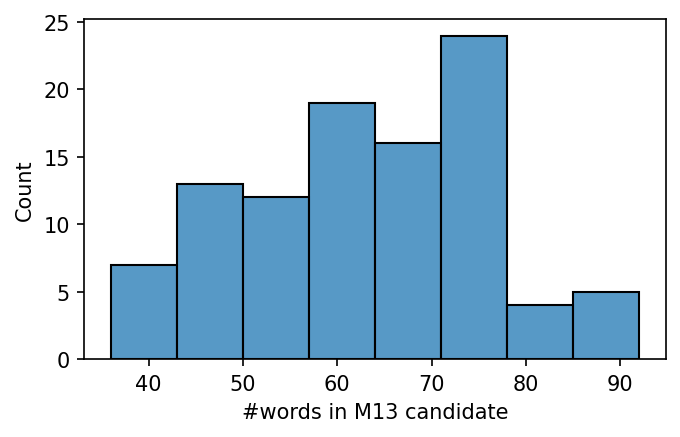

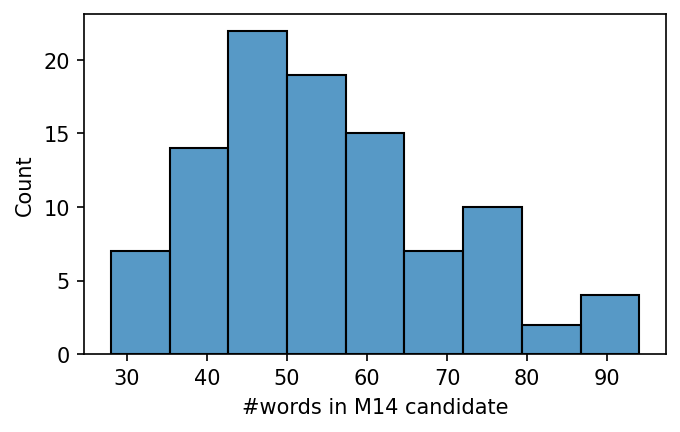

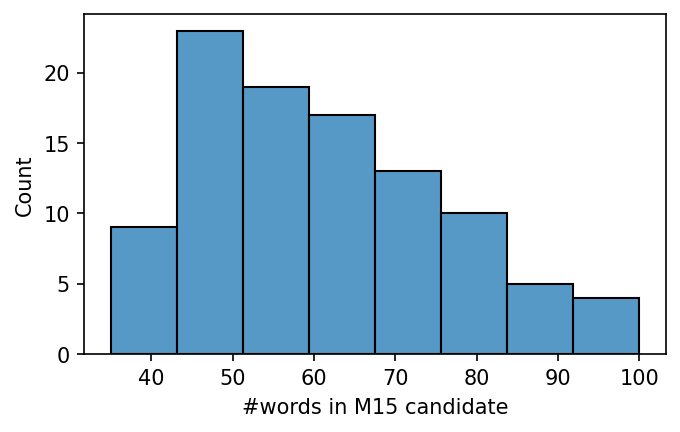

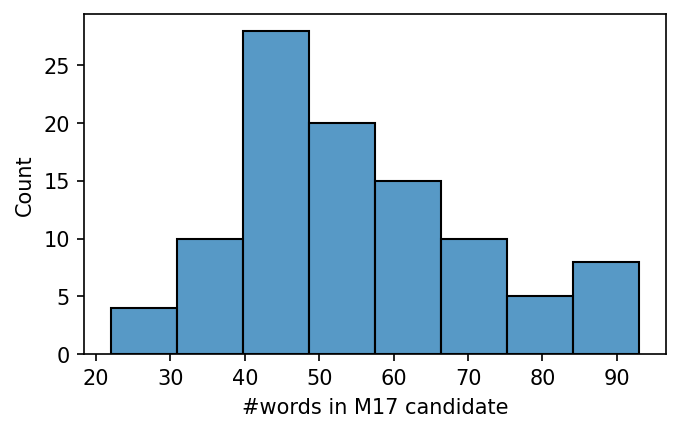

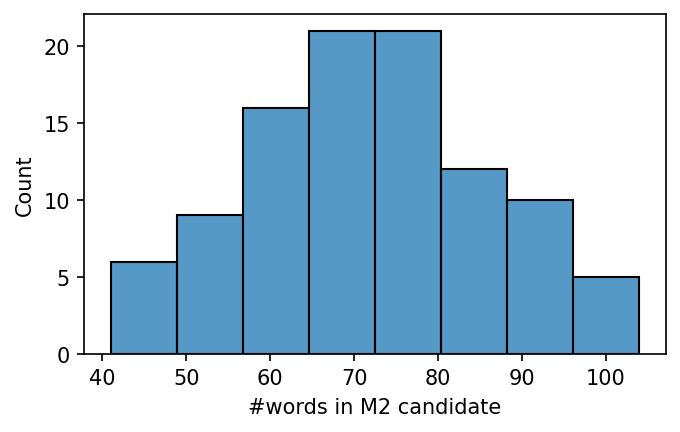

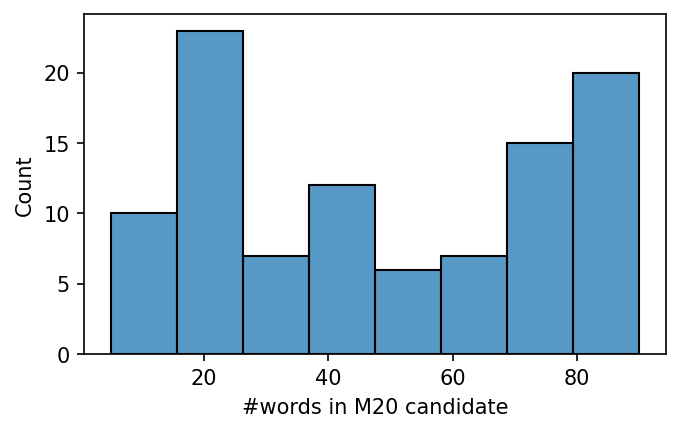

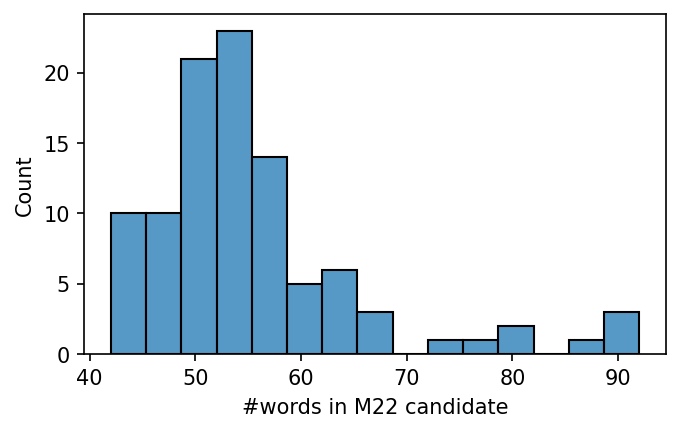

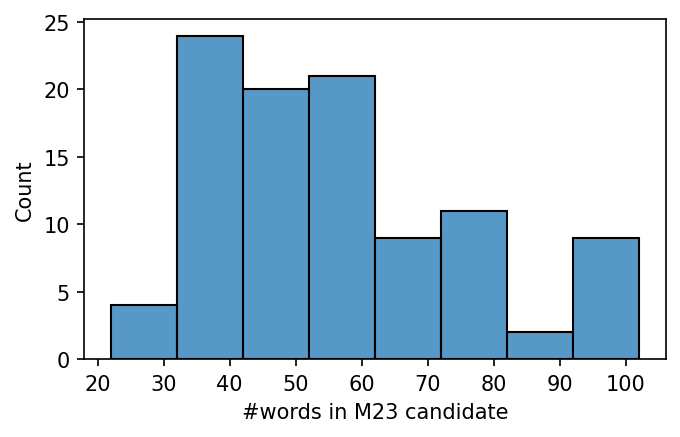

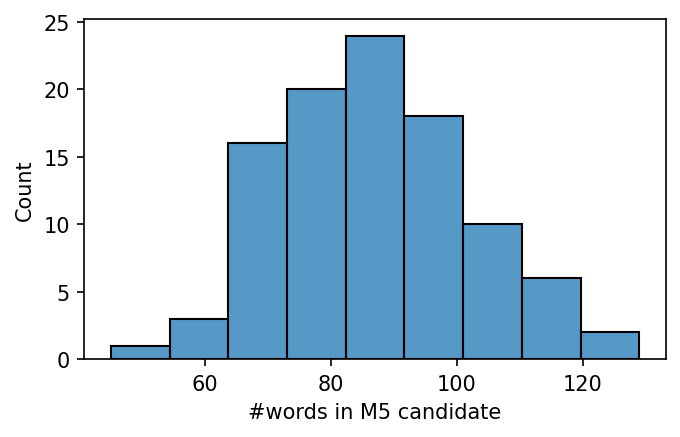

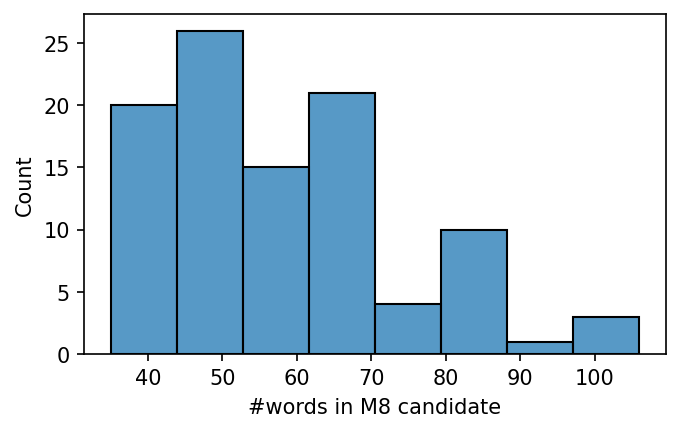

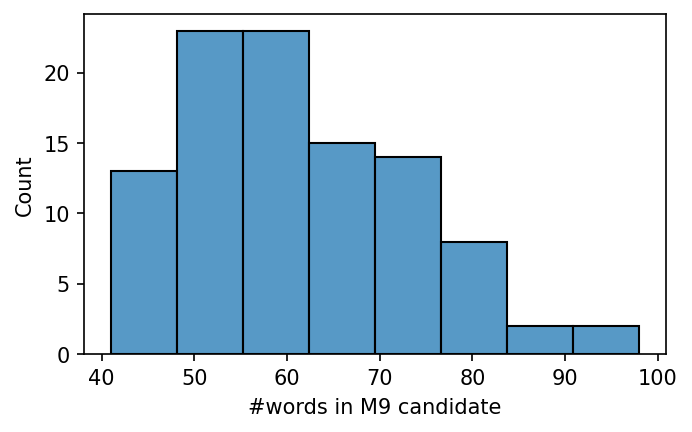

In [72]:
plot_summeval_dists(summ_eval_flu, "fluency", plot_models=True)

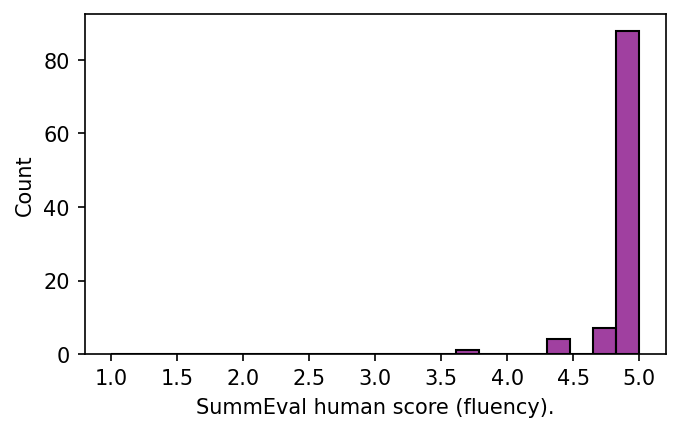

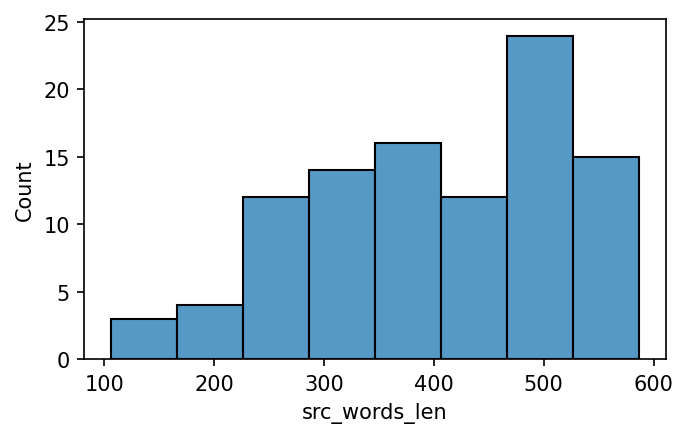

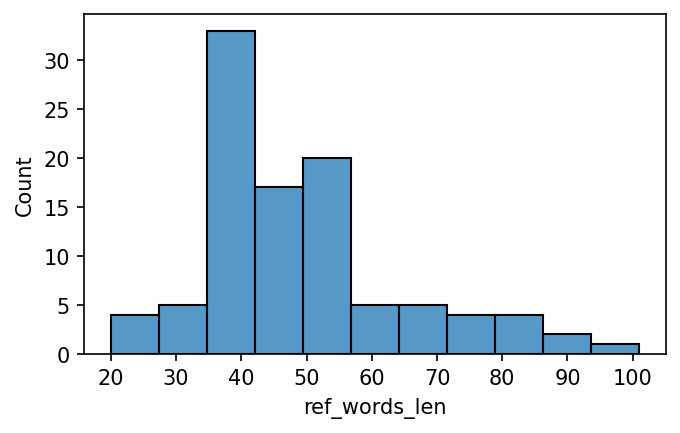

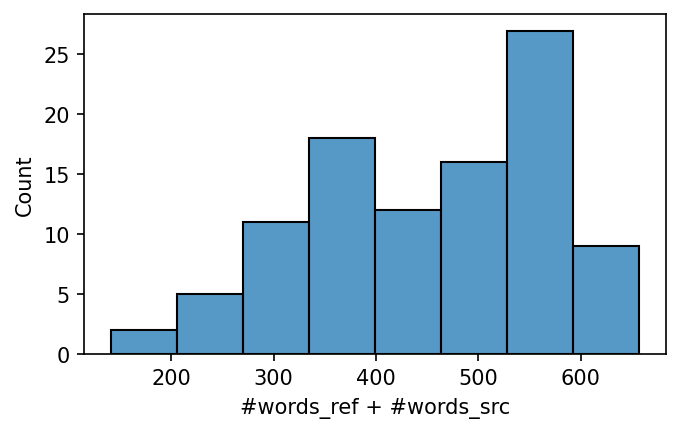

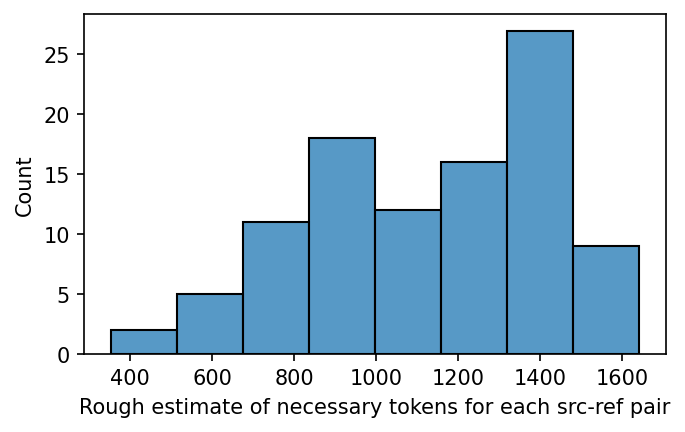

In [70]:
plot_summeval_dists(summ_eval_flu, "fluency")

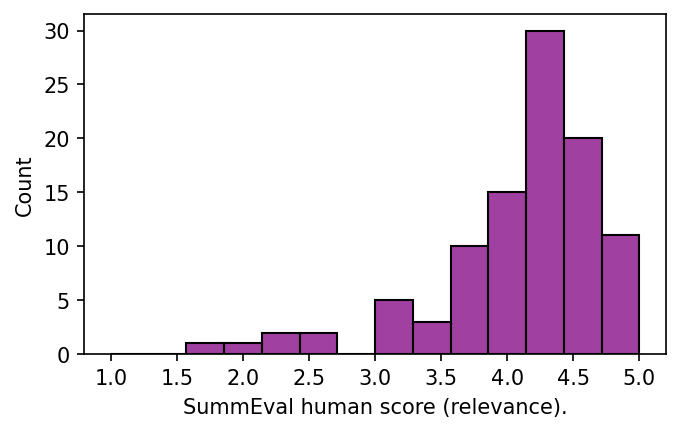

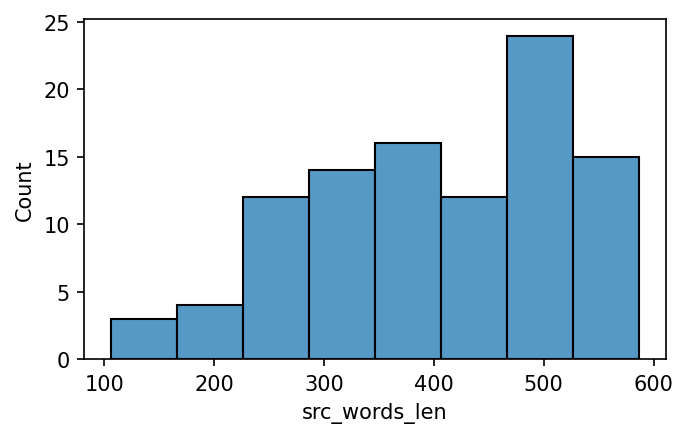

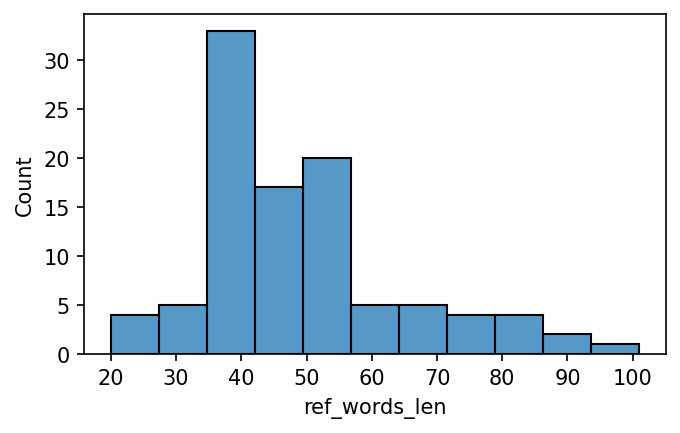

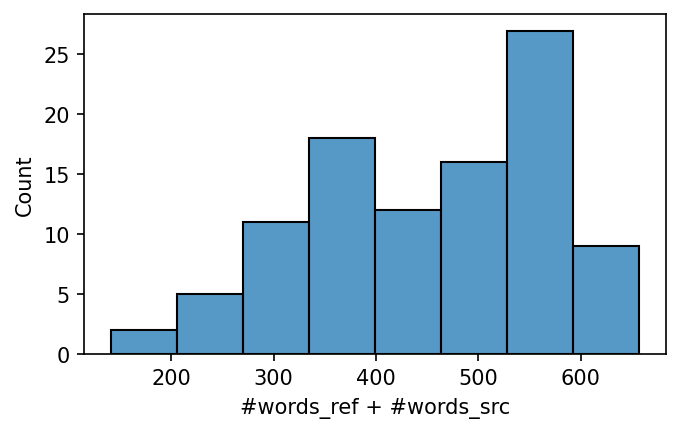

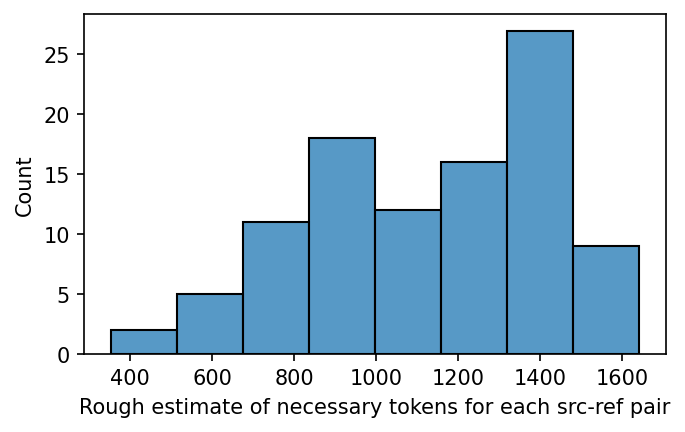

In [71]:
plot_summeval_dists(summ_eval_rel, "relevance")

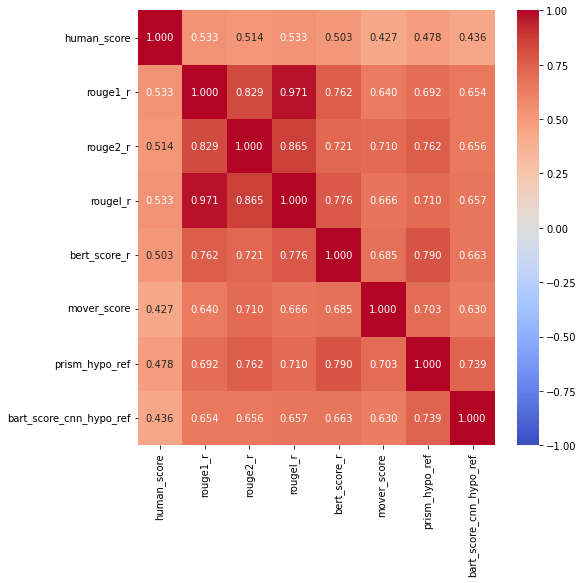

In [16]:
def heatmap(data, method="spearman", title="", figsize=(20, 15)):
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.heatmap(data.corr(method=method), vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".3f")
    plt.show()

# Remove prompt templates
cols = [c for c in model_data.columns if ("_de" not in c) and ("_en" not in c)]
# Remove id column
cols = cols[1:]

# Paper metrics (table 4)
summ_metrics = [
    'human_score', 
    'rouge1_r',
    'rouge2_r',
    'rougel_r',
    'bert_score_r',
    'mover_score',
    'prism_hypo_ref',
    'bart_score_cnn_hypo_ref',
]

heatmap(model_data[summ_metrics], figsize=(8, 8))

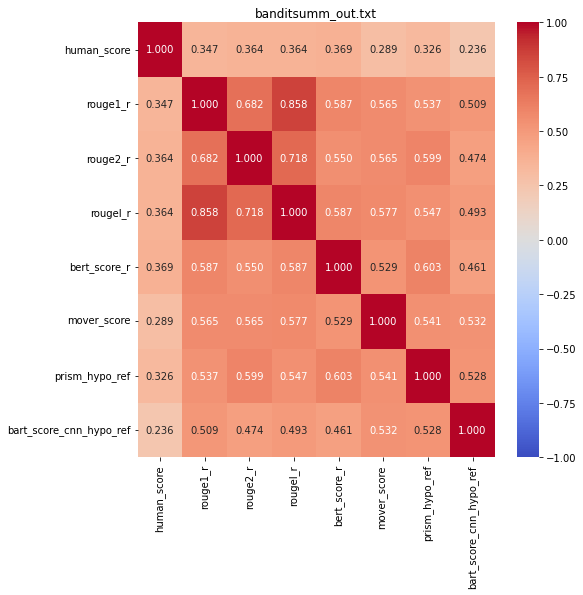

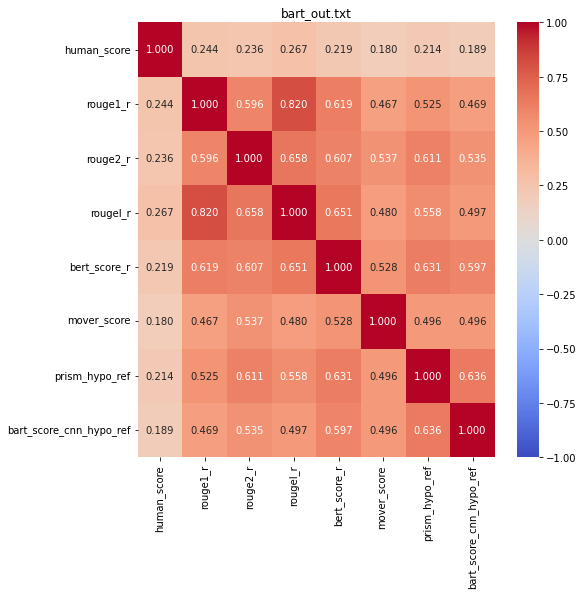

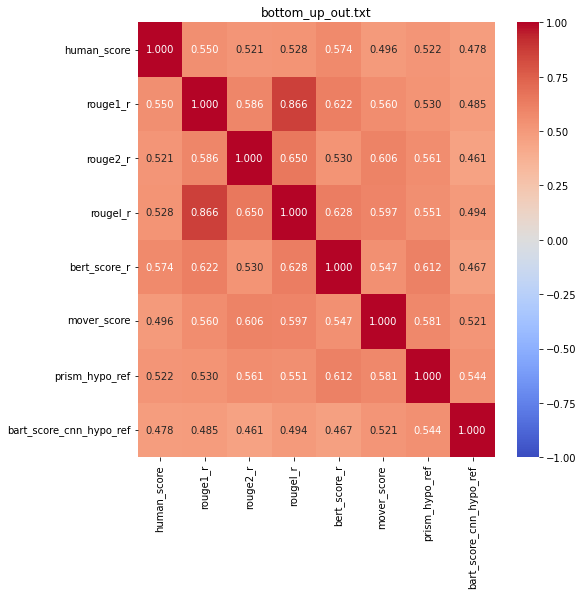

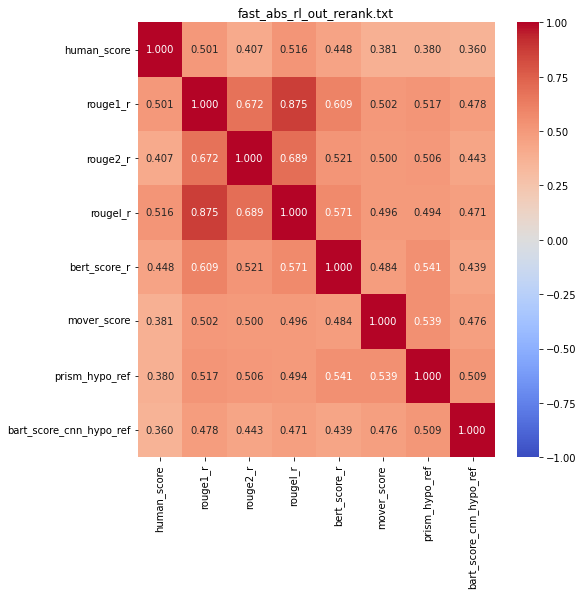

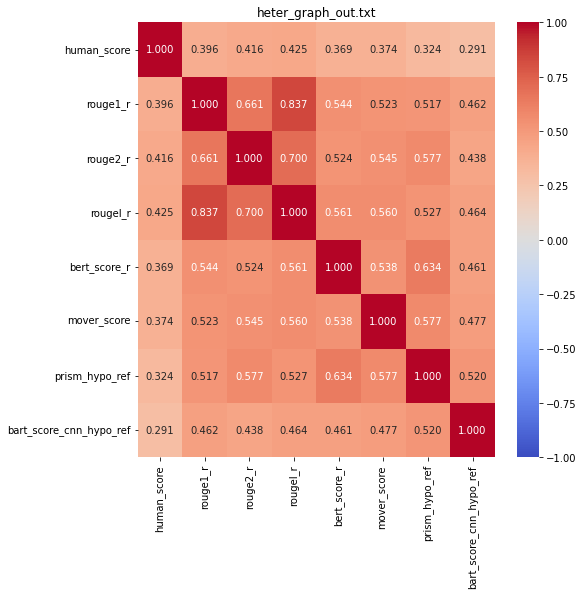

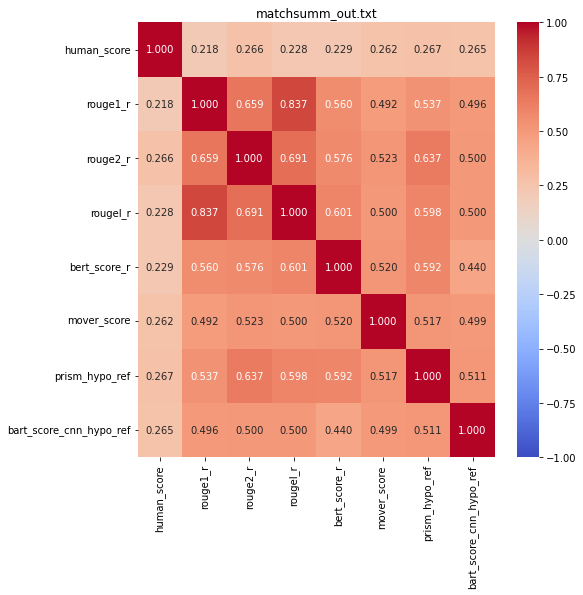

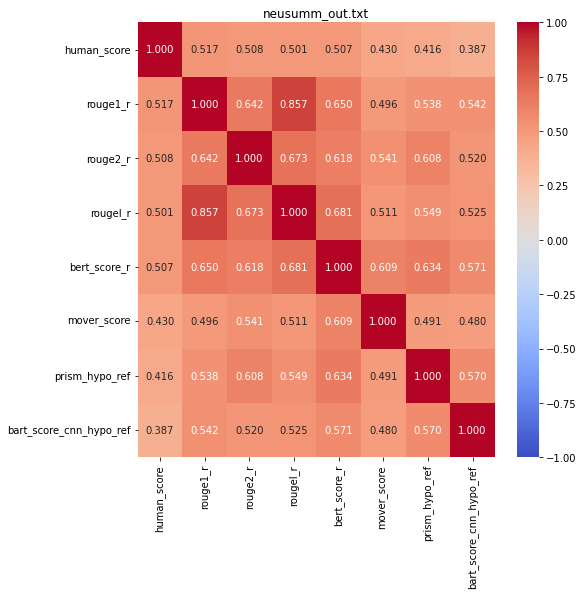

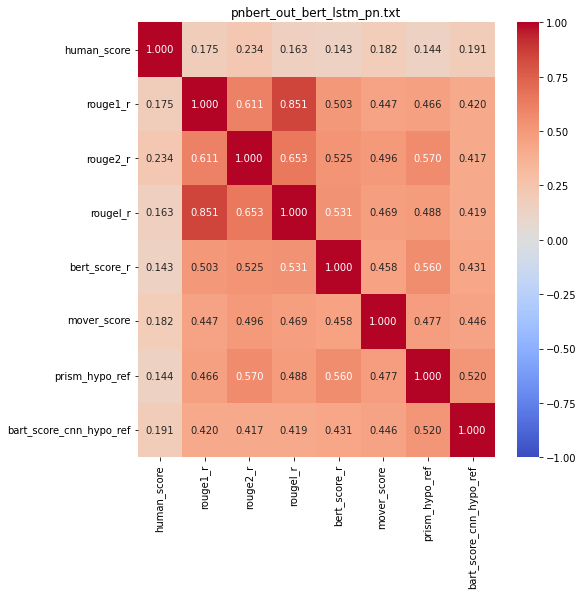

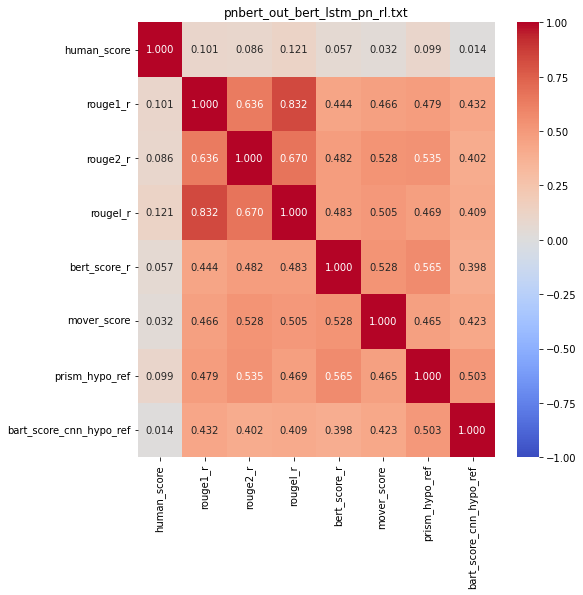

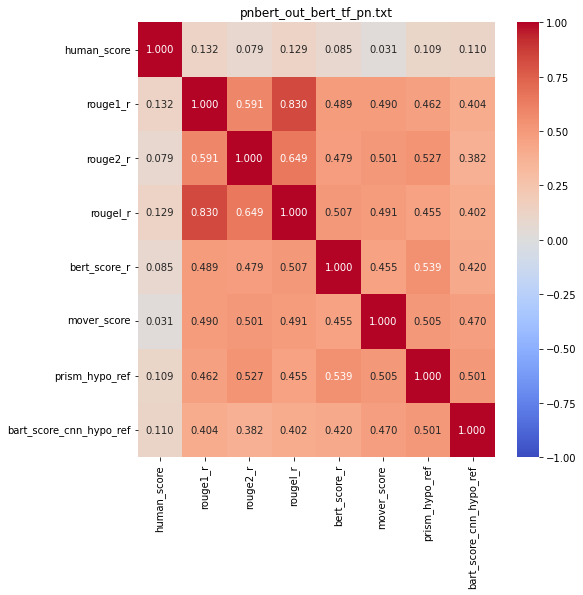

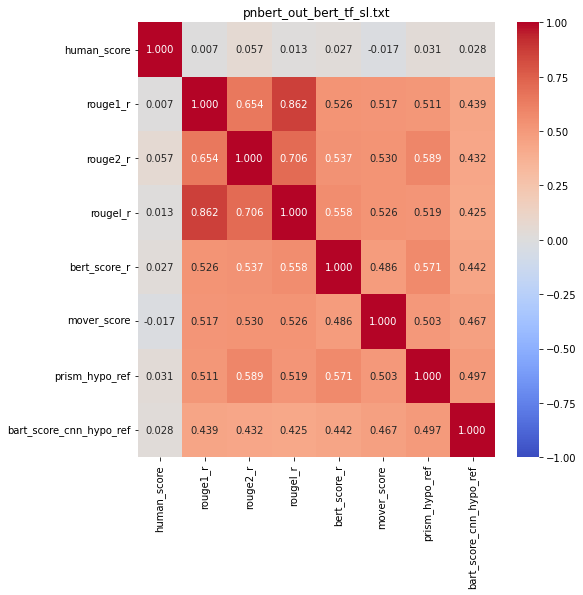

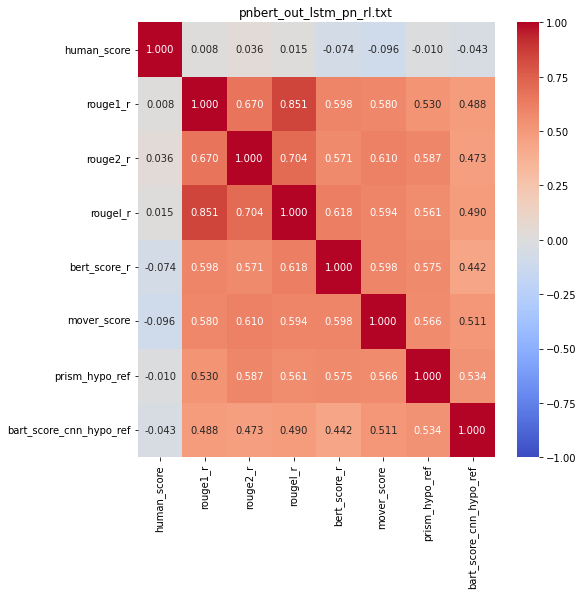

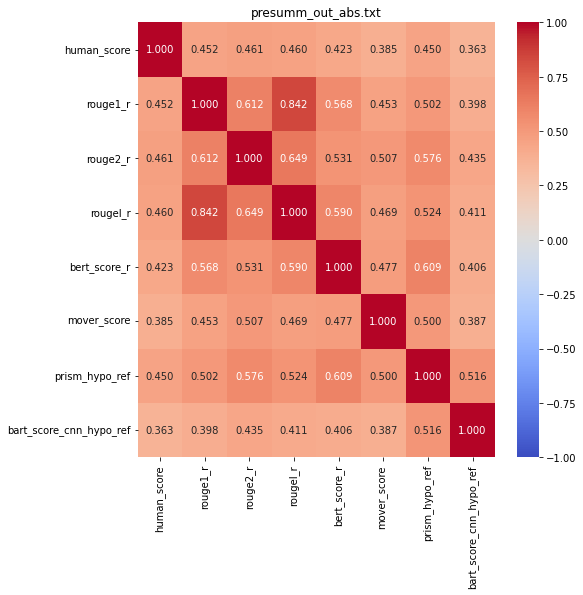

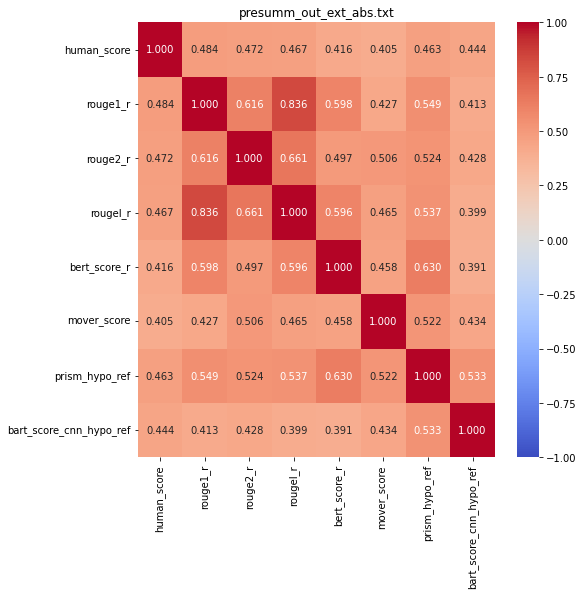

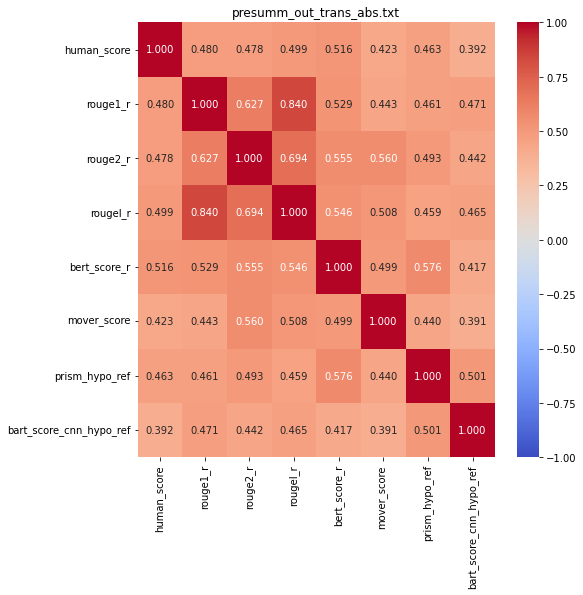

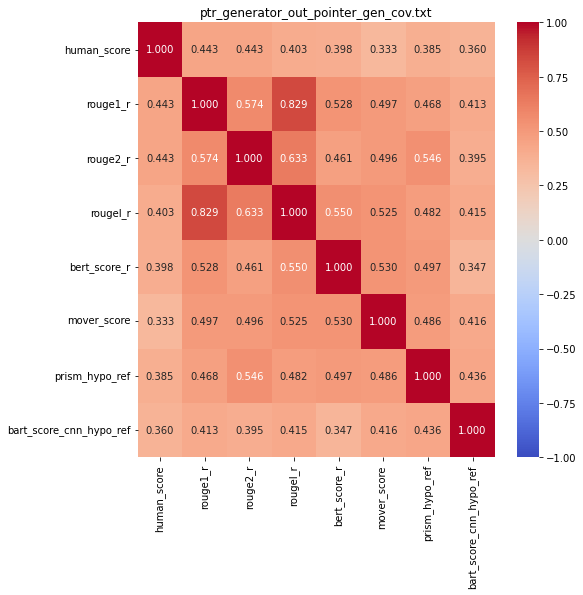

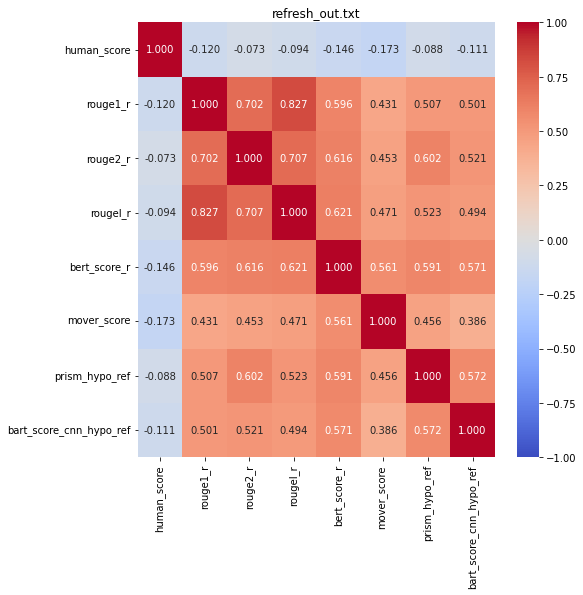

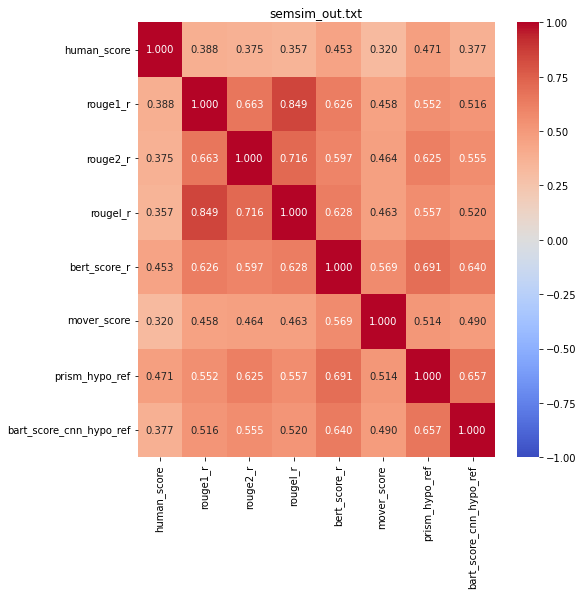

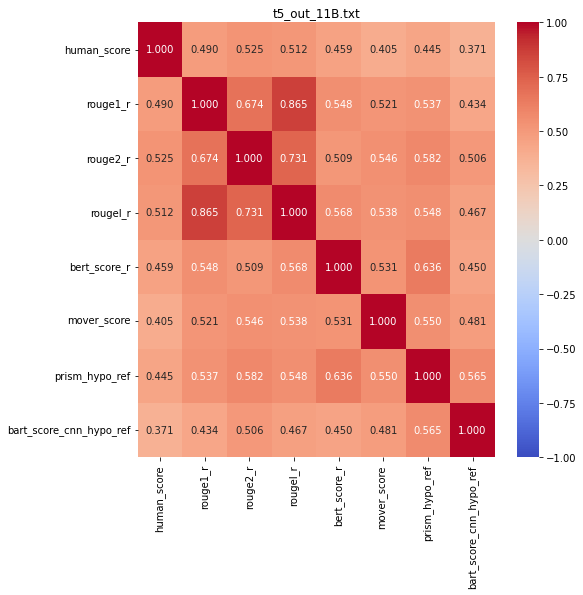

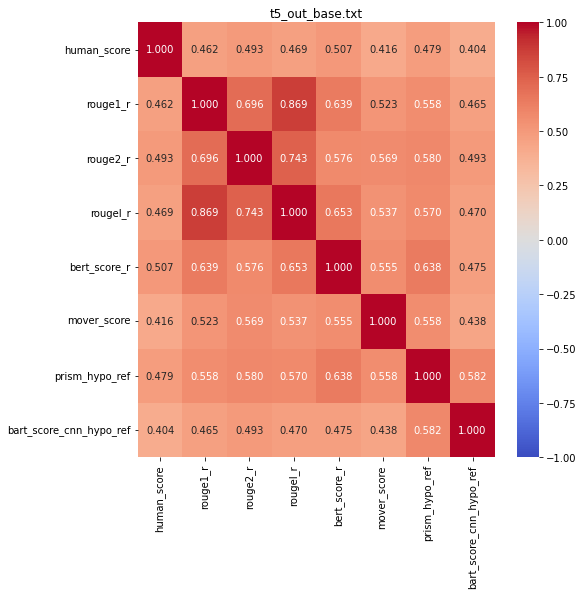

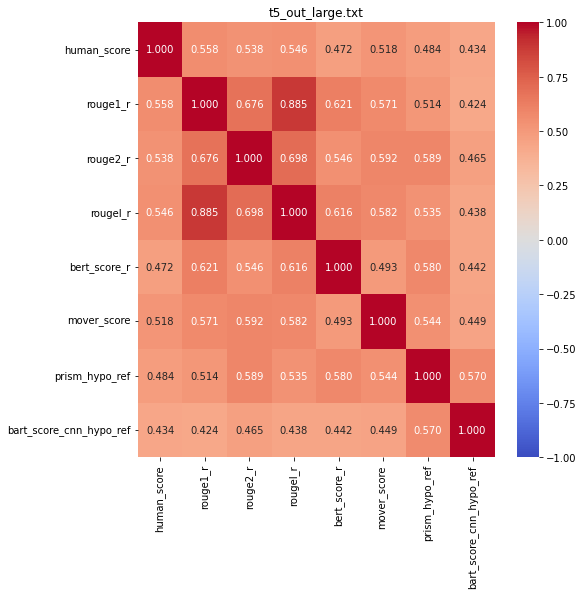

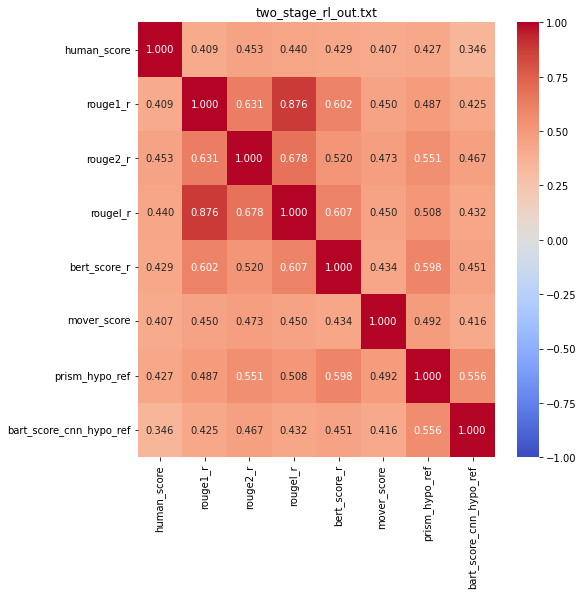

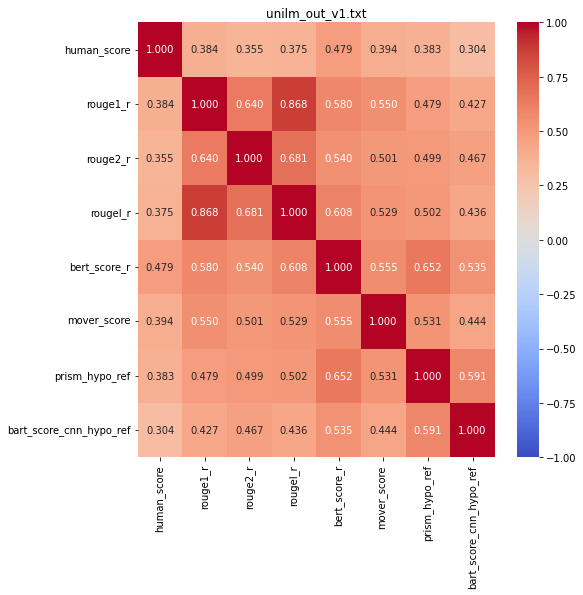

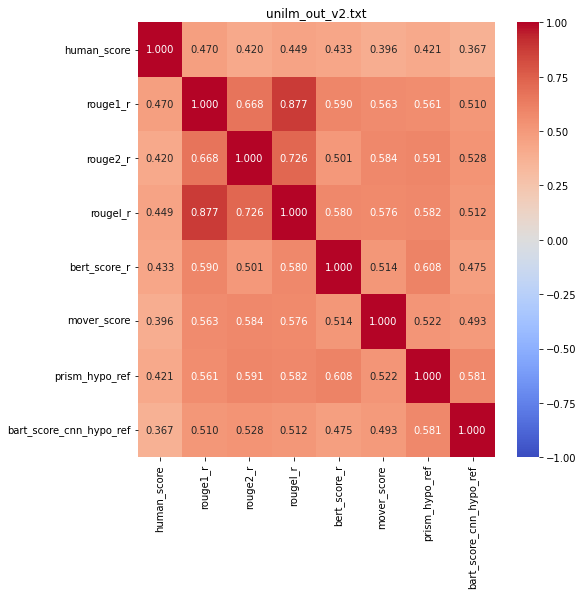

In [16]:
# Correlation by model
for model in sorted(model_data.model.unique()):
    data = model_data[model_data.model == model][summ_metrics].copy()
    heatmap(data, method="kendall", title=model, figsize=(8, 8))

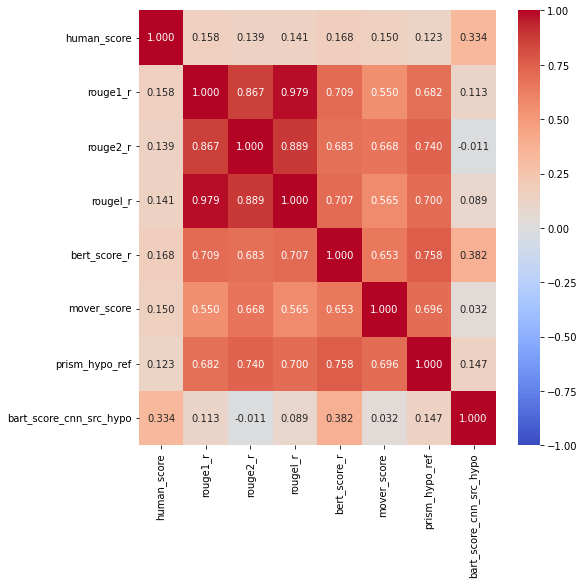

In [22]:
 # Remove prompt templates
cols = [c for c in summ_eval_con.columns if ("_de" not in c) and ("_en" not in c)]
# Remove id column
cols = cols[1:]

# Paper metrics (table 4)
summ_metrics = [
    'human_score', 
    'rouge1_r',
    'rouge2_r',
    'rougel_r',
    'bert_score_r',
    'mover_score',
    'prism_hypo_ref',
    'bart_score_cnn_src_hypo',
]

heatmap(summ_eval_con[summ_metrics], figsize=(8, 8))

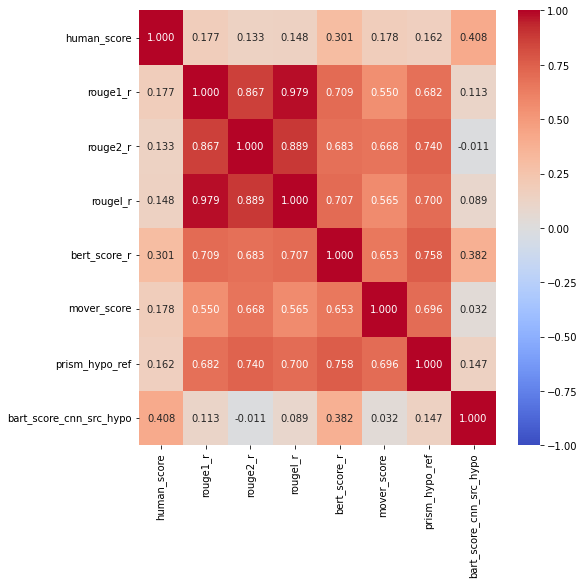

In [23]:
 # Remove prompt templates
cols = [c for c in summ_eval_coh.columns if ("_de" not in c) and ("_en" not in c)]
# Remove id column
cols = cols[1:]

# Paper metrics (table 4)
summ_metrics = [
    'human_score', 
    'rouge1_r',
    'rouge2_r',
    'rougel_r',
    'bert_score_r',
    'mover_score',
    'prism_hypo_ref',
    'bart_score_cnn_src_hypo',
]

heatmap(summ_eval_coh[summ_metrics], figsize=(8, 8))

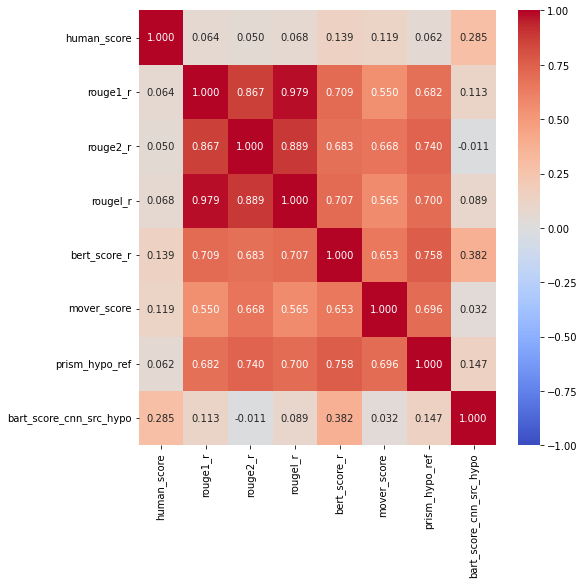

In [24]:
 # Remove prompt templates
cols = [c for c in summ_eval_flu.columns if ("_de" not in c) and ("_en" not in c)]
# Remove id column
cols = cols[1:]

# Paper metrics (table 4)
summ_metrics = [
    'human_score', 
    'rouge1_r',
    'rouge2_r',
    'rougel_r',
    'bert_score_r',
    'mover_score',
    'prism_hypo_ref',
    'bart_score_cnn_src_hypo',
]

heatmap(summ_eval_flu[summ_metrics], figsize=(8, 8))

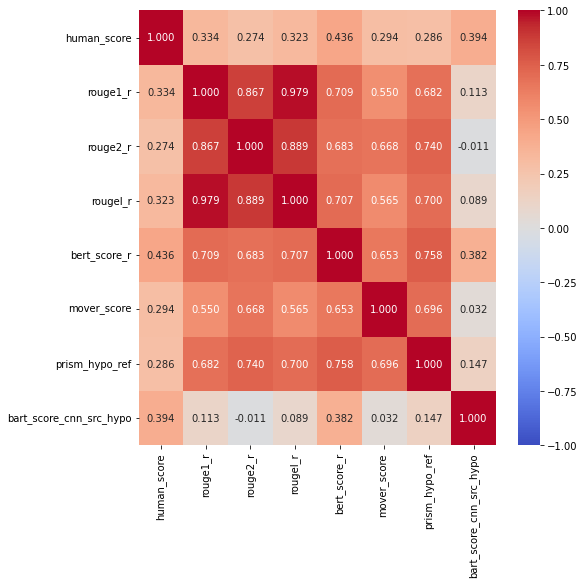

In [25]:
 # Remove prompt templates
cols = [c for c in summ_eval_rel.columns if ("_de" not in c) and ("_en" not in c)]
# Remove id column
cols = cols[1:]

# Paper metrics (table 4)
summ_metrics = [
    'human_score', 
    'rouge1_r',
    'rouge2_r',
    'rougel_r',
    'bert_score_r',
    'mover_score',
    'prism_hypo_ref',
    'bart_score_cnn_src_hypo',
]

heatmap(summ_eval_rel[summ_metrics], figsize=(8, 8))

Evaluation dataset: 373 examples
Comparing metrics fact


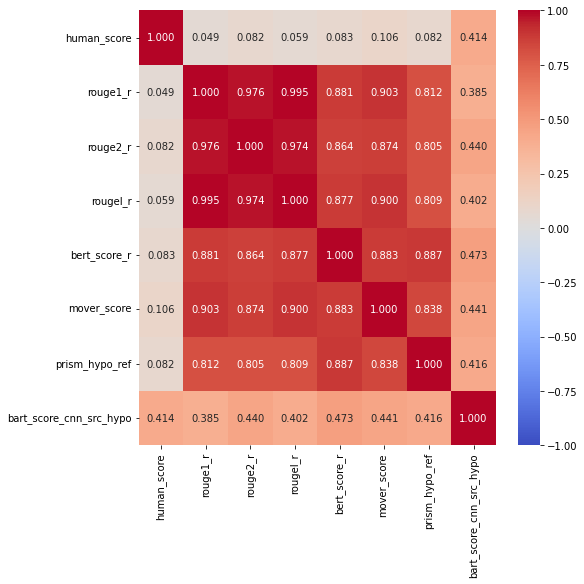

In [29]:
summ_stat = SUMStat('SUM/Rank19/final_p.pkl') # The path to the scored file, _p means we have prompted metrics
rank19 = get_dataframe(summ_stat.data, "fact")

 # Remove prompt templates
cols = [c for c in rank19.columns if ("_de" not in c) and ("_en" not in c)]
# Remove id column
cols = cols[1:]


heatmap(rank19[summ_metrics], figsize=(8, 8))

Evaluation dataset: 235 examples
Comparing metrics fact


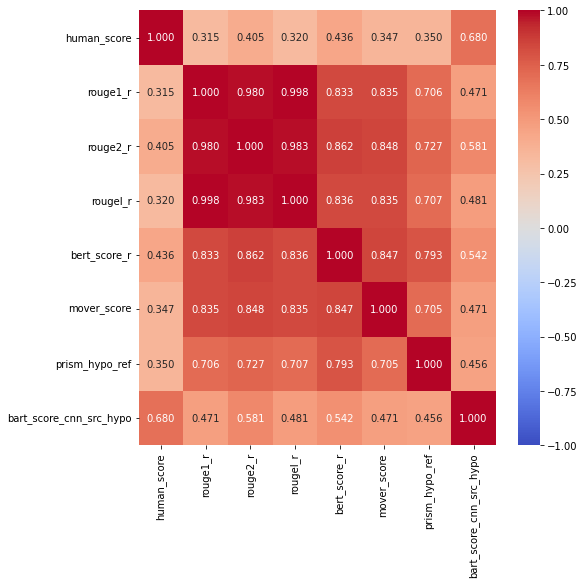

In [31]:
summ_stat = SUMStat('SUM/QAGS_CNN/final_p.pkl') # The path to the scored file, _p means we have prompted metrics
qags_cnn = get_dataframe(summ_stat.data, "fact")

 # Remove prompt templates
cols = [c for c in qags_cnn.columns if ("_de" not in c) and ("_en" not in c)]
# Remove id column
cols = cols[1:]


heatmap(qags_cnn[summ_metrics], figsize=(8, 8))

Evaluation dataset: 239 examples
Comparing metrics fact


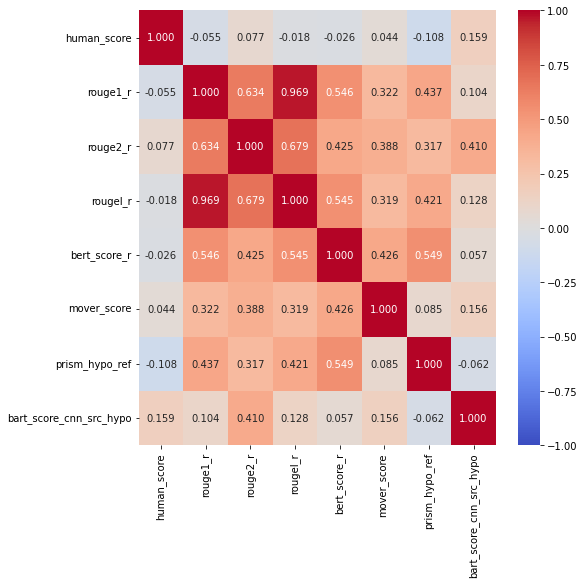

In [32]:
summ_stat = SUMStat('SUM/QAGS_XSUM/final_p.pkl') # The path to the scored file, _p means we have prompted metrics
qags_xsum = get_dataframe(summ_stat.data, "fact")

 # Remove prompt templates
cols = [c for c in qags_xsum.columns if ("_de" not in c) and ("_en" not in c)]
# Remove id column
cols = cols[1:]


heatmap(qags_xsum[summ_metrics], figsize=(8, 8))

In [30]:
summ_stat = SUMStat('SUM/QAGS_CNN/final_p.pkl') # The path to the scored file, _p means we have prompted metrics
summ_stat.human_metrics

['fact']

### Analysis

In [17]:
def output_disparate_summ_examples(data, metric1, metric2, dataset, cuttoff=0.25, output_dir="./outputs", extra_cols=None):
    from sklearn.preprocessing import MinMaxScaler
    
    feature_range = (
        data[metric1].min(),
        data[metric1].max(),
    )
    
    print(feature_range)
    scaler = MinMaxScaler(feature_range)

    data = data.copy().sort_values(by=metric1)
    data[f"{metric2}_scaled"] = scaler.fit_transform(data[[metric2]])
    data["diff"] = np.abs(data[metric1] - data[f"{metric2}_scaled"])
    
    cols = ["summary", "model", "reference", "candidate","diff", metric1, f"{metric2}_scaled", metric2, "id"]
    if extra_cols:
        cols += extra_cols
        
    # Plot distribution of differences
    sns.histplot(data=data["diff"], bins=20, binrange=np.array(feature_range) - 1)
    plt.title(f"{dataset} ({metric2})")
    plt.show()
    
    # Let us consider the difference in terms of more than 0.2 in the score
    data = data[data["diff"] >= cuttoff]
    data = data.sort_values(["model", "diff"], ascending=False)[cols]
    
    
    data.to_csv(f"{output_dir}/{dataset}_big_diff.csv")

Evaluation dataset: 100 examples
Comparing metrics litepyramid_recall
(0.0, 1.0)


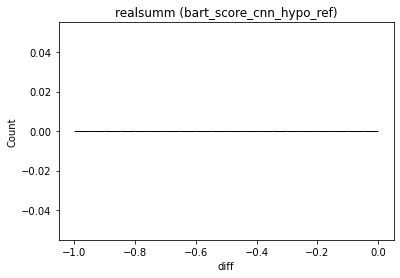

In [18]:
### REALSUMM ANALYSIS
summ_stat = SUMStat('SUM/REALSumm/final_p.pkl') # The path to the scored file, _p means we have prompted metrics
realsumm_data = get_dataframe(summ_stat.data, "litepyramid_recall")
output_disparate_summ_examples(realsumm_data, "human_score", "bart_score_cnn_hypo_ref", "realsumm")

In [ ]:
### SummEval ANALYSIS
summ_stat = SUMStat('SUM/SummEval/final_p.pkl')

print('[Human metrics]')
truncate_print(summ_stat.human_metrics)

# Based on the values in the table
# Coherence (COH) --> bart_score_cnn_src_hypo
# Consistency (FAC) --> bart_score_cnn_src_hypo
# Fluency (FLU) --> bart_score_cnn_src_hypo
# Relevance (INFO) --> bart_score_cnn_src_hypo

# By comparing the spearman results reported in the table, 
# it seems that they use the same probability to measure different aspects of quality
auto_metric = "bart_score_src_hypo"
summeval_coh_data = get_dataframe(summ_stat.data, "coherence")
output_disparate_summ_examples(summeval_coh_data, "human_score",  auto_metric, f"summstat_coherence_{auto_metric}", extra_cols=["consistency", "fluency", "relevance"])

summeval_fac_data = get_dataframe(summ_stat.data, "consistency")
output_disparate_summ_examples(summeval_fac_data, "human_score",  auto_metric, f"summstat_factuality_{auto_metric}", extra_cols=["coherence", "fluency", "relevance"])

summeval_flu_data = get_dataframe(summ_stat.data, "fluency")
output_disparate_summ_examples(summeval_flu_data, "human_score",  auto_metric, f"summstat_fluency_{auto_metric}", extra_cols=["coherence", "consistency", "relevance"])

summeval_info_data = get_dataframe(summ_stat.data, "relevance")
output_disparate_summ_examples(summeval_info_data, "human_score", auto_metric, f"summstat_informativeness_{auto_metric}", extra_cols=["coherence", "consistency", "fluency"])

In [ ]:
### Newsroom ANALYSIS
ner_stat = SUMStat('SUM/Newsroom/final_p.pkl')

print('[Human metrics]')
truncate_print(ner_stat.human_metrics)

# Like summeval, all four distinct aspects are compared against
# src -> hypo BARTScore variant
auto_metric = "bart_score_src_hypo"


# By comparing the spearman results reported in the table, 
# it seems that they use the same probability to measure different aspects of quality
auto_metric = "bart_score_src_hypo"
ner_coh_data = get_dataframe(ner_stat.data, "coherence")
output_disparate_summ_examples(ner_coh_data, "human_score",  auto_metric, f"ner18_coherence_{auto_metric}", extra_cols=["fluency", "informativeness", "relevance"])

ner_flu_data = get_dataframe(ner_stat.data, "fluency")
output_disparate_summ_examples(ner_flu_data, "human_score",  auto_metric, f"ner18_fluency_{auto_metric}", extra_cols=["coherence", "informativeness", "relevance"])

ner_info_data = get_dataframe(ner_stat.data, "informativeness")
output_disparate_summ_examples(ner_info_data, "human_score", auto_metric, f"ner18_informativeness_{auto_metric}", extra_cols=["coherence", "fluency", "relevance"])

ner_relevance_data = get_dataframe(ner_stat.data, "relevance")
output_disparate_summ_examples(ner_relevance_data, "human_score",  auto_metric, f"ner18_relevance_{auto_metric}", extra_cols=["coherence", "informativeness", "fluency"])

### Factuality 

Rank19

In [76]:
fact_stat = SUMStat('SUM/Rank19/final_p.pkl')
fact_stat.combine_prompt()

# Set valid metrics
valid_metrics = [
    'rouge1_f',
    'rouge2_f',
    'rougel_f',
    'bert_score_f',
    'mover_score',
    'prism_src_hypo',
    'bart_score_cnn_src_hypo',
    'bart_score_cnn_src_hypo_de'
]

# Print accuracy, take a list of metrics
fact_stat.get_fact_acc(valid_metrics)

metric                           acc
--------------------------  --------
bart_score_cnn_src_hypo     0.836461
bart_score_cnn_src_hypo_de  0.796247
prism_src_hypo              0.780161
bert_score_f                0.713137
mover_score                 0.713137
rouge2_f                    0.630027
rougel_f                    0.587131
rouge1_f                    0.568365


In [77]:
fact_stat.data[0]["sys_summs"]["correct"]

{'sys_summ': "Those who receive centrelink payments made up half of radio rental 's income last year .",
 'scores': {'fact': 1,
  'bert_score_p': tensor(0.8449),
  'bert_score_r': tensor(0.6454),
  'bert_score_f': tensor(0.7438),
  'mover_score': 0.6871090620182698,
  'bart_score_src_hypo': -1.8763917684555054,
  'bart_score_hypo_ref': -2.317399263381958,
  'bart_score_ref_hypo': -1.8763917684555054,
  'bart_score_avg_f': -2.0968955159187317,
  'bart_score_harm_f': -1.036853975084585,
  'bart_score_cnn_src_hypo': -0.35266631841659546,
  'bart_score_cnn_hypo_ref': -1.755808711051941,
  'bart_score_cnn_ref_hypo': -0.35266631841659546,
  'bart_score_cnn_avg_f': -1.0542375147342682,
  'bart_score_cnn_harm_f': -0.2936788841775164,
  'bart_score_para_src_hypo': -1.059096336364746,
  'bart_score_para_hypo_ref': -2.14009428024292,
  'bart_score_para_ref_hypo': -1.059096336364746,
  'bart_score_para_avg_f': -1.599595308303833,
  'bart_score_para_harm_f': -0.7084810764054532,
  'prism_ref_hypo':

### QAGS-CNN

CNN

In [73]:
fact_stat = SUMStat('SUM/QAGS_CNN/final_p.pkl')
fact_stat.combine_prompt()

# Set valid metrics
valid_metrics = [
    'rouge1_f',
    'rouge2_f',
    'rougel_f',
    'bert_score_f',
    'mover_score',
    'prism_src_hypo',
    'bart_score_cnn_src_hypo',
    'bart_score_cnn_src_hypo_de'
]

# Print accuracy, take a list of metrics
fact_stat.get_fact_pearson(valid_metrics)

metric                        pearson
--------------------------  ---------
bart_score_cnn_src_hypo      0.734672
bart_score_cnn_src_hypo_de   0.718525
bert_score_f                 0.575994
prism_src_hypo               0.478689
rouge2_f                     0.459141
mover_score                  0.41414
rougel_f                     0.356889
rouge1_f                     0.337667


In [74]:
fact_stat.human_metrics

['fact']

# Machine Translation


For all language pairs, the analysis tools are the same. We begin by looking at reference length statistics.

In [78]:
wmt_stat = WMTStat('WMT/kk-en/final_p.pkl')
wmt_stat.print_ref_len()

Mean reference length: 17.75
Max reference length: 180
Min reference length: 1
20% percentile: 10.0
80% percentile: 25.0
90% percentile: 31.0


In [81]:
wmt_stat.data[20]

{'src': '40 жасқа жетпей "Қазақтың өлең құрылысы" атты диссертацияны қорғап, филология ғылымдарының докторы ғылыми дәрежесін иеленді.',
 'ref': 'At the age below 40, he defended the thesis named "Kazakh poem structure" and awarded the degree of DLitt.',
 'better': {'sys': 'He received his thesis "Building Kazakh verse" at the age of 40.',
  'scores': {'bleu': '4.490848803920189',
   'chrf': '0.21953250914514993',
   'bleurt': '-0.3523866832256317',
   'prism': '-2.7764382',
   'comet': '-0.3188309371471405',
   'bert_score': '0.908055',
   'bart_score': '-5.925045728683472',
   'bart_score_cnn': '-3.4209905862808228',
   'bart_score_para': '-3.2462295293807983',
   'bart_score_para_en_Such as': '-3.3789294958114624',
   'bart_score_para_de_Such as': '-3.629392623901367'},
  'sys_name': 'CUNI-T2T-transfer-kken.6436'},
 'worse': {'sys': 'The author of the "Kazakh poet" was awarded the title of the "Kazakh poet" and "The History of the Great Steppe."',
  'scores': {'bleu': '5.255923420816

In [ ]:
from collections import defaultdict
import pandas as pd

results = defaultdict(list)

count = 0
# metric = "bart_score"
metric = "bart_score_cnn"

for example_id, example in wmt_stat.data.items():
    if float(example["better"]["scores"][metric]) < float(example["worse"]["scores"][metric]):
        #print(example["better"]["scores"][metric], "vs", example["worse"]["scores"][metric], 
        # example["better"]["sys"], example["worse"]["sys"])
        results["id"].append(example_id)
        results[f"reference"].append(example["ref"])
        results[f"better_{metric}"].append(example["better"]["scores"][metric])
        results[f"worse_{metric}"].append(example["worse"]["scores"][metric])
        results[f"better"].append(example["better"]["sys"])
        results[f"worse"].append(example["worse"]["sys"])

wmt_data = pd.DataFrame(results)
wmt_data[f"better_{metric}"] = wmt_data[f"better_{metric}"].astype(float)
wmt_data[f"worse_{metric}"] = wmt_data[f"worse_{metric}"].astype(float) 

# wmt_data["delta"] = np.abs(np.exp(wmt_data[f"better_{metric}"]) - np.exp(wmt_data[f"worse_{metric}"]))
#sns.histplot(wmt_data["delta"])
#wmt_data = wmt_data.sort_values(by="delta", ascending=False)
#wmt_data.drop_duplicates(wmt_data.columns[1:], inplace=True)
#len(wmt_data)

In [ ]:
from WMT.bart_score import BARTScorer

# bart_scorer = BARTScorer(device="cuda", checkpoint='facebook/bart-large-cnn')

bart_scorer = BARTScorer(device="cuda", checkpoint='facebook/bart-large-cnn')
bart_scorer.load()

In [ ]:
def run_bartscore(scorer, mt: list, ref: list, batch_size=4):
    hypo_ref = np.array(scorer.score(mt, ref, batch_size=4))
    ref_hypo = np.array(scorer.score(ref, mt, batch_size=4))
    avg_f = 0.5 * (ref_hypo + hypo_ref)
    return avg_f, hypo_ref, ref_hypo


reference = "Money transfers within the country reached 50.9 billion tenge, increased 4 times."
hypotheses = [
    "Money transfers within the country amounted to 50.9 billion tenge and increased 4 times.",
    "Money transfers within the country reached to 50.9 billion tenge and increased 4 times.",
    "Money transfers within the country reached to 50.9 billion tenge increased 4 times.",
    "Money transfers within the country amounted to 50.9 billion tenge, increased 4 times.",
    reference,    
]

references = len(hypotheses) * [reference]

scores, hyp_ref, ref_hyp = run_bartscore(bart_scorer, hypotheses, references)
print("Scores:", scores)
print("exp(scores):", np.exp(scores))


print("Hyp_ref (exp(scores)):", np.exp(hyp_ref))
print("Ref_hyp (exp(scores)):", np.exp(ref_hyp))

### (experiments) Paraphrasing


#### Load the model

In [ ]:
# Load the model 
from WMT.bart_score import BARTScorer as WMTBARTScorer

bart_scorer = WMTBARTScorer(device="cpu", checkpoint='facebook/bart-large-cnn')
# Machine translation model will download the paraphrased version by default
bart_scorer.load()

#### Datasets

In [ ]:
import datasets 

sts = datasets.load_dataset("stsb_multi_mt", "en")

#### Examples

In [ ]:
def run_bartscore(scorer, mt: list, ref: list, batch_size=4):
    hypo_ref = np.array(scorer.score(mt, ref, batch_size=4))
    ref_hypo = np.array(scorer.score(ref, mt, batch_size=4))
    avg_f = 0.5 * (ref_hypo + hypo_ref)
    return avg_f, hypo_ref, ref_hypo

In [ ]:
sim_score = sts["dev"]["similarity_score"]
sentences1 = sts["dev"]["sentence1"]
sentences2 = sts["dev"]["sentence2"]

scores1, hyp_ref1, ref_hyp1 = run_bartscore(bart_scorer, sentences1, sentences2)
scores2, hyp_ref2, ref_hyp2 = run_bartscore(bart_scorer, sentences2, sentences1)

In [ ]:
from scipy.stats import pearsonr, kendalltau

print("pearson:", round(pearsonr(scores1, sim_score)[0], 2), "| kendall:", round(kendalltau(scores1, sim_score).correlation, 2))
print("pearson:", round(pearsonr(hyp_ref1, sim_score)[0], 2), "| kendall:", round(kendalltau(hyp_ref1, sim_score).correlation, 2))
print("pearson:", round(pearsonr(ref_hyp1, sim_score)[0], 2), "| kendall:", round(kendalltau(ref_hyp1, sim_score).correlation, 2))

In [ ]:
from scipy.stats import pearsonr, kendalltau

print("pearson:", round(pearsonr(scores1, scores2)[0], 2), "| kendall:", round(kendalltau(scores1, scores2).correlation, 2))
print("pearson:", round(pearsonr(hyp_ref1, hyp_ref2)[0], 2), "| kendall:", round(kendalltau(hyp_ref1, hyp_ref2).correlation, 2))
print("pearson:", round(pearsonr(ref_hyp1, ref_hyp2)[0], 2), "| kendall:", round(kendalltau(ref_hyp1, ref_hyp2).correlation, 2))

In [ ]:
import pandas as pd 

df = pd.DataFrame({
    "sentence1": sentences1,
    "sentence2": sentences2,
    "similarity_score": sts["dev"]["similarity_score"],
    "BARTScore_para_avg_f": scores1,
    "BARTScore_para_s1->s2": ref_hyp1,
    "BARTScore_para_s2->s1": hyp_ref1,
})
df.to_csv("eval_stsb_multi_mt_bartscore.csv")

In [ ]:
df_sorted = df.sort_values("similarity_score")
df_sorted["len_s1"] = df["sentence1"].apply(len)
df_sorted["len_s2"] = df["sentence2"].apply(len)

x = np.arange(len(df)) + 1
y1 = round(df_sorted.similarity_score / 5, 2)
y2 = round(np.exp(df_sorted["BARTScore_para_avg_f"]), 2)

sns.lineplot(x=x, y=y1)
sns.lineplot(x=x, y=y2)
plt.ylabel("Evaluation value")
plt.show()

In [ ]:
df_sorted = df.sort_values("similarity_score")
x = np.arange(len(df)) + 1
y1 = round(df_sorted.similarity_score / 5, 2)
y2 = round(np.exp(df_sorted["BARTScore_para_s1->s2"]), 2)

sns.lineplot(x=x, y=y1)
sns.lineplot(x=x, y=y2)
plt.ylabel("Evaluation value")
plt.show()

In [ ]:
df_sorted = df.sort_values("similarity_score")
x = np.arange(len(df)) + 1
y1 = round(df_sorted.similarity_score / 5, 2)
y2 = round(np.exp(df_sorted["BARTScore_para_s2->s1"]), 2)

sns.lineplot(x=x, y=y1)
sns.lineplot(x=x, y=y2)
plt.ylabel("Evaluation value")
plt.show()

In [ ]:
df_sorted_len_s1 = df_sorted.sort_values("len_s1")

x = np.arange(len(df)) + 1
y1 = round(df_sorted_len_s1.similarity_score / 5, 2)
y2 = round(np.exp(df_sorted_len_s1["BARTScore_para_avg_f"]), 2)

print(kendalltau(df_sorted.len_s1, df_sorted.similarity_score))
print(kendalltau(df_sorted.len_s1, df_sorted["BARTScore_para_avg_f"]))
print(kendalltau(df_sorted.len_s1, df_sorted["BARTScore_para_s1->s2"]))
print(kendalltau(df_sorted.len_s1, df_sorted["BARTScore_para_s2->s1"]))

print(kendalltau(df_sorted.len_s2, df_sorted.similarity_score))
print(kendalltau(df_sorted.len_s2, df_sorted["BARTScore_para_avg_f"]))
print(kendalltau(df_sorted.len_s2, df_sorted["BARTScore_para_s1->s2"]))
print(kendalltau(df_sorted.len_s2, df_sorted["BARTScore_para_s2->s1"]))

In [ ]:
sentence_pairs = [
    ["Three men are playing guitars.", "Three men are on stage playing guitars."],
    ["A young child is riding a horse.", "A child is riding a horse."],
    ["A woman peels a potato.", "A woman is peeling a potato."], 
    ["A man with a hard hat is dancing.", "A man wearing a hard hat is dancing."],
]

In [ ]:
i, MAX = 0, 20
for sentence in sts["dev"]:
    s1 = sentence["sentence1"]
    s2 = sentence["sentence2"]
    print("s1:", s1)
    print("s2:", s2)
    print("score:", sentence["similarity_score"])

    scores1 = run_bartscore(bart_scorer, [s1], [s2])
    scores2 = run_bartscore(bart_scorer, [s2], [s1])
    
    scores1 = [round(np.exp(s)[0], 2) for s in scores1]
    scores2 = [round(np.exp(s)[0], 2) for s in scores2]
    
    print("s2->s1:", scores1)
    print("s1->s2:", scores2)
    print()
    
    i += 1
    if i > MAX:
        break

#### Specific examples

In [ ]:
r1 = "A woman is cutting an onion."
r2 = "A woman is cutting an onion."

scores = run_bartscore(bart_scorer, [r1], [r2])

print("s1:", r1)
print("s2:", r2)
print("BARTscore:", scores)
print()

In [ ]:
r1 = "A woman and a man are cutting an onion."
r2 = r1

scores = run_bartscore(bart_scorer, [r1], [r2])

print("s1:", r1)
print("s2:", r2)
print("BARTscore:", scores)
print()


scores = run_bartscore(bart_scorer, [r2], [r1])

print("s1:", r1)
print("s2:", r2)
print("BARTscore:", scores)
print()

In [ ]:
r1 = "I like you."
r2 = r1

scores = run_bartscore(bart_scorer, [r1], [r2])

print("s1:", r1)
print("s2:", r2)
print("BARTscore:", scores)
print()

In [ ]:
r1 = "I love you."
r2 = r1

scores = run_bartscore(bart_scorer, [r1], [r2])

print("s1:", r1)
print("s2:", r2)
print("BARTscore:", scores[0])
print()

In [ ]:
r1 = "I adore you."
r2 = "I love you."

scores, hyp_ref, ref_hyp = run_bartscore(bart_scorer, [r1], [r2])

print("s1:", r1)
print("s2:", r2)
print("BARTscore:", round(scores[0], 2))
print()

In [ ]:
r1 = "The said that he liked you."
r2 = r1

scores, hyp_ref, ref_hyp = run_bartscore(bart_scorer, [r1], [r2])

print("s1:", r1)
print("s2:", r2)
print("BARTscore:", round(scores[0], 2))
print()

In [ ]:
r1 = "The club of Chess gathers every wednesday night."
r2 = r1

scores, hyp_ref, ref_hyp = run_bartscore(bart_scorer, [r1], [r2])

print("s1:", r1)
print("s2:", r2)
print("BARTscore:", round(scores[0], 2))
print()

In [ ]:
r1 = "The club of Chess gathers every wednesday night."
r2 = "The Chess club gathers every wednesday night."

scores, hyp_ref, ref_hyp = run_bartscore(bart_scorer, [r1], [r2])

print("s1:", r1)
print("s2:", r2)
print("BARTscore:", round(scores[0], 2))
print()

In [ ]:
sns.regplot(x=scores, y=sts["dev"]["similarity_score"], )